# Foundations of Data Mining: Assignment 2

Please complete all assignments in this notebook. You should submit this notebook, as well as a PDF version (See File > Download as).

In [2]:
%matplotlib inline
from preamble import *
plt.rcParams['savefig.dpi'] = 100 # This controls the size of your figures
# Comment out and restart notebook if you only want the last output of each cell.
InteractiveShell.ast_node_interactivity = "all" 
from sklearn import svm
from sklearn.datasets.samples_generator import make_blobs

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import train_test_split
from scipy.stats import expon
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import Imputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import *
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SelectPercentile, f_regression
from sklearn import pipeline, ensemble, preprocessing
from astropy.table import Table
from sklearn.ensemble import RandomForestClassifier  
from sklearn import ensemble
from openml import tasks, runs
import xmltodict
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import ensemble
from scipy.stats import distributions
from sklearn.ensemble import (RandomForestClassifier,
                              RandomForestRegressor,
                              GradientBoostingRegressor)
from sklearn.model_selection import (GridSearchCV, RandomizedSearchCV,
                                     ShuffleSplit, StratifiedKFold,
                                     cross_val_score, train_test_split)
from sklearn.ensemble import (RandomForestClassifier,
                              RandomForestRegressor,
                              GradientBoostingRegressor)
from sklearn.linear_model import (LogisticRegression, Lasso,
                                  Ridge, LinearRegression)
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import accuracy_score, r2_score
import GPy
import numpy

DEBUG = True

In [3]:
# This is a temporary read-only OpenML key. Replace with your own key later. 
oml.config.apikey = '7c68800374e7375d7a1a957da2e60f1d'

## Kernel selection (4 points (1+2+1))
SVMs can be trained with different kernels. Generate a 2-dimensional dataset as shown below and study the effect of the choice of kernel by visualizing the results.

- Train a SVM classifier on the dataset using respectively a linear, polynomial and radial basis function (RBF) kernel, evaluate the performance of each kernel using 10-fold cross-validation and AUC. Which one works best? Visualize the results. Can you intuitively explain why one kernel is more suited than another?
    - Hint: you can use the visualization code used in class. It is under mglearn/plot_svm.py > plot_svm_kernels().
- Take the RBF kernel and vary both the C parameter and the kernel width ($\gamma$). Use 3 values for each (a very small, default, and very large value). For each of the 9 combinations, create the same RBF plot as before, report the number of support vectors, and the AUC performance. Explain the performance results. When are you over/underfitting?
    - Hint: values for C and $\gamma$ are typically in [$2^{-15}..2^{15}$] on a log scale. 
    - Hint: don't count the support vectors manually, retrieve them from the trained SVM.
- Vary C and $\gamma$ again, but this time use a grid of at least 20x20, vary both parameters uniformly on a log scale, and visualise the results using a $C \times \gamma \rightarrow AUC$ heatmap. Explain the performance results, and compare them to the 9 results obtained in the previous subquestion. Can you also tell in which regions of the heatmap you are over/underfitting?
    - Hint: We've constructed such a heatmap in class and in assignment 1.

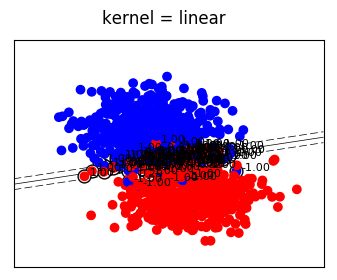

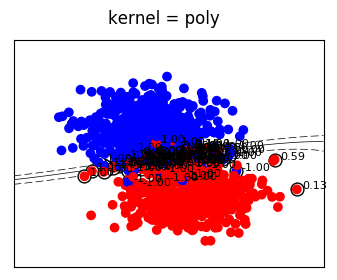

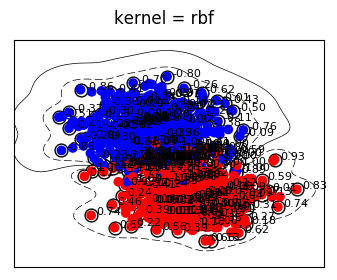

The AUC of linear kernel is: 0.994
The AUC of poly kernel is: 0.993
The AUC of rbf kernel is: 0.977


In [19]:
X, y = make_blobs(centers=2, n_samples=1000, random_state=0)

def plot_svm_kernels(X, Y):
    # figure number
    fignum = 1

    # fit the model
    for kernel in ('linear', 'poly', 'rbf'):
        clf = svm.SVC(kernel=kernel, gamma=2)
        clf.fit(X, Y)

        # plot the line, the points, and the nearest vectors to the plane
        plt.figure(fignum, figsize=(4, 3))
        plt.suptitle('kernel = %s' % kernel)

        plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
                    s=85, edgecolors='k', c='w', zorder=10)
        plt.scatter(X[:, 0], X[:, 1], c=Y, zorder=10, cmap=plt.cm.bwr)

        for i, coef in enumerate(clf.dual_coef_[0]):
            plt.annotate("%0.2f" % (coef), (clf.support_vectors_[i, 0]+0.15,clf.support_vectors_[i, 1]), fontsize=8, zorder=11)

        plt.axis('tight')
        x_min = -3
        x_max = 6
        y_min = -3
        y_max = 9

        XX, YY = np.mgrid[x_min:x_max:200j, y_min:y_max:200j]
        Z = clf.decision_function(np.c_[XX.ravel(), YY.ravel()])

        # Put the result into a color plot
        Z = Z.reshape(XX.shape)
        plt.figure(fignum, figsize=(4, 3))
        #plt.pcolormesh(XX, YY, Z > 0, cmap=plt.cm.bwr, alpha=0.1)
        plt.contour(XX, YY, Z, colors=['k', 'k', 'k'], linestyles=['--', '-', '--'],
                    levels=[-.5, 0, .5])

        plt.xlim(x_min, x_max)
        plt.ylim(y_min, y_max)

        plt.xticks(())
        plt.yticks(())
        fignum = fignum + 1
    plt.show()

plot_svm_kernels(X, y)

# Linearly separable data
clf_linear = svm.SVC(kernel='linear')
clf_poly = svm.SVC(kernel='poly')
clf_rbf = svm.SVC(kernel='rbf')

clf_linear_auc = cross_val_score(clf_linear, X, y, scoring="roc_auc", cv=10)
clf_poly_auc = cross_val_score(clf_poly, X, y, scoring="roc_auc", cv=10)
clf_rbf_auc = cross_val_score(clf_rbf, X, y, scoring="roc_auc", cv=10)

print("The AUC of linear kernel is: {:.3f}".format(clf_linear_auc.mean()))
print("The AUC of poly kernel is: {:.3f}".format(clf_poly_auc.mean()))
print("The AUC of rbf kernel is: {:.3f}".format(clf_rbf_auc.mean()))

### Compare score among three different kernels
Linear kernel has the highest score among all score, hence it is the most suitable. The reason is that data are approximately distributed linearly.

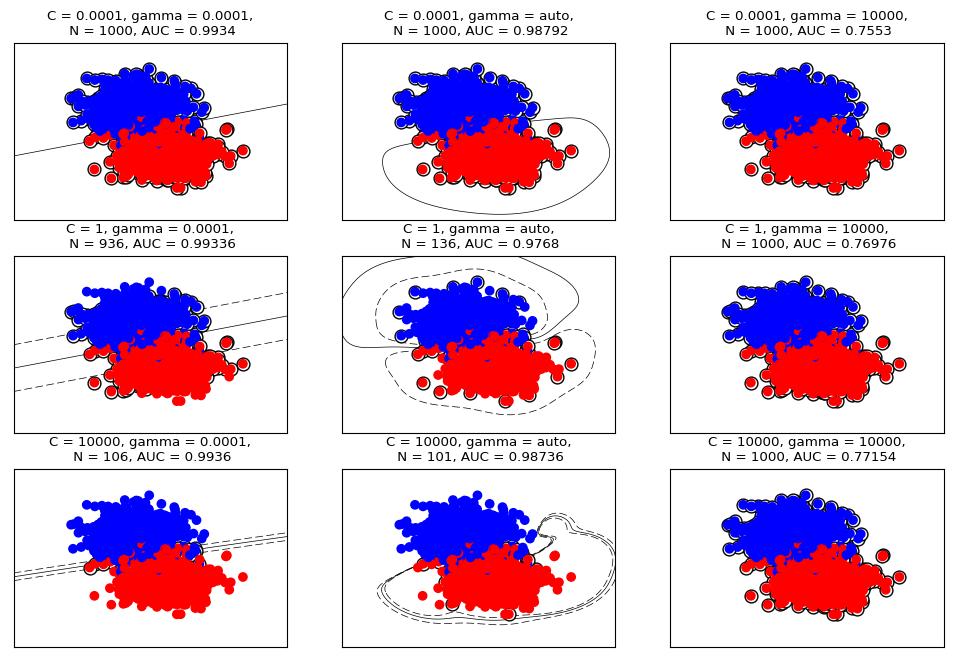

In [27]:
# RBF kernel with varying both the C parameter and the kernel width ( γγ )
auc = 0
auc_scores = []
i = 1
def plot_svm_rbf(X, y):
    # figure number
    fignum = 1
    plt.figure(figsize=(12, 8))

    # fit the model
#     for C in [10**-15,1,10**15]:
#         for gamma in [10**-15,1,10**15]:
    for C in [0.0001,1,10000]:
        for gamma in [0.0001,1,10000]:
            if gamma == 1:
                rbf = svm.SVC(kernel='rbf', C=C, gamma='auto')
            else:
                rbf = svm.SVC(kernel='rbf', C=C, gamma=gamma)
            rbf.fit(X,y)
            
            auc = cross_val_score(rbf, X, y, scoring="roc_auc", cv=10)
            auc_scores.append(auc.mean())
            
            plt.subplot(3,3,fignum)
           # plt.tight_layout()
            
            if gamma == 1:
                plt.title('C = %s, gamma = %s,\n N = %s, AUC = %s' % (C, 'auto', len(rbf.support_vectors_[:]),auc.mean()))
            else:
                plt.title('C = %s, gamma = %s,\n N = %s, AUC = %s' % (C, gamma, len(rbf.support_vectors_[:]),auc.mean()))
            
            plt.scatter(rbf.support_vectors_[:, 0], rbf.support_vectors_[:, 1],
                    s=85, edgecolors='k', c='w', zorder=10)
            plt.scatter(X[:, 0], X[:, 1], c=y, zorder=10, cmap=plt.cm.bwr)
            
            plt.axis('tight')
            x_min = -4
            x_max = 7
            y_min = -4
            y_max = 9
        
            XX, YY = np.mgrid[x_min:x_max:200j, y_min:y_max:200j]
            Z = rbf.decision_function(np.c_[XX.ravel(), YY.ravel()])

            # Put the result into a color plot
            Z = Z.reshape(XX.shape)
            #plt.pcolormesh(XX, YY, Z > 0, cmap=plt.cm.bwr, alpha=0.1)
            plt.contour(XX, YY, Z, colors=['k', 'k', 'k'], linestyles=['--', '-', '--'],
                       levels=[-.5, 0, .5])

            plt.xlim(x_min, x_max)
            plt.ylim(y_min, y_max)

            plt.xticks(())
            plt.yticks(())
            fignum = fignum+1

plot_svm_rbf(X, y)

### Analysis the performance results
According to the results above, the following observation are obseved
- When gamma is small, if C is small then it is underfitting. When C becomes big then it becomes overfitting.
- When gamma is big, whatever how big C is, it is always overfitting.

{'kernel': ['rbf'], 'C': [0.0001220703125, 0.000244140625, 0.00048828125, 0.0009765625, 0.001953125, 0.00390625, 0.0078125, 0.015625, 0.03125, 0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192], 'gamma': [0.0001220703125, 0.000244140625, 0.00048828125, 0.0009765625, 0.001953125, 0.00390625, 0.0078125, 0.015625, 0.03125, 0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192]}


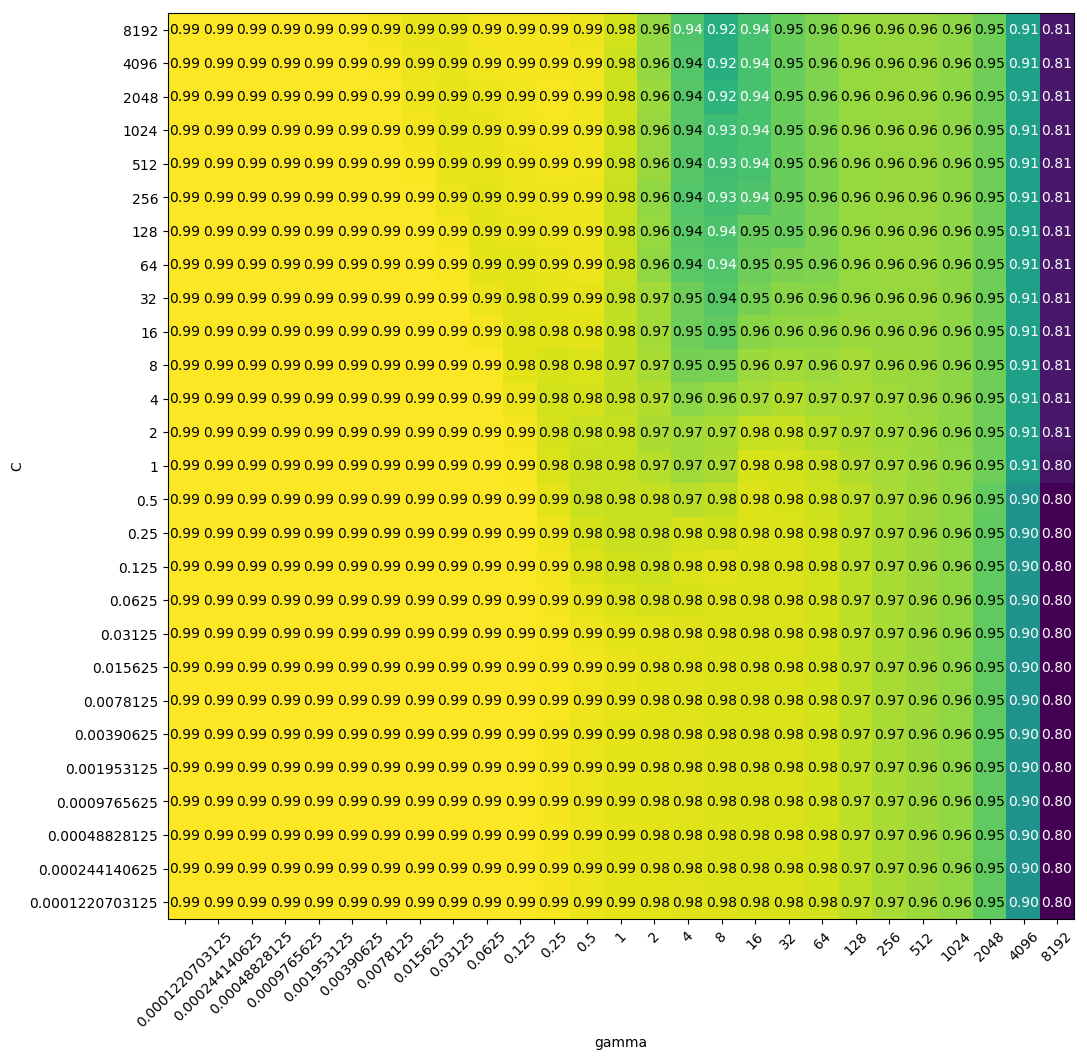

In [55]:
from matplotlib.ticker import FormatStrFormatter
X, y = make_blobs(centers=2, n_samples=1000, random_state=0)
param_grid = {'kernel': ['rbf'],
              'C': [2**i for i in range(-13,14)],
              'gamma': [2**i for i in range(-13,14)]}
print(param_grid)
grid_search = GridSearchCV(svm.SVC(), param_grid=param_grid, cv=10)
grid_search.fit(X, y)
results = pd.DataFrame(grid_search.cv_results_)
scores = np.array(results.mean_test_score).reshape(27, 27)
# plot the mean cross-validation scores
fig, ax = plt.subplots(figsize=(12, 12))


ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=45)
# ax.set_xscale('log', basex=2)
# ax.set_yscale('log', basey=2)

mglearn.tools.heatmap(scores, xlabel='gamma', xticklabels=param_grid['gamma'],
                      ylabel='C', yticklabels=param_grid['C'], cmap="viridis", fmt="%0.2f", ax=ax);


### Heatmap Analysis
- Large gamma leads to overfitting because 'bubbles' tent to wrap the points of a class tighter as gamma gets larger. 
- Large C leads to underfitting because the harder you penalize the thiner margin you get. And a thin margin will leads to underfitting.


## Robots and SVMs (4 points (2+1+1))

The [Wall Robot Navigation dataset](http://www.openml.org/d/1497) contains about 5500 readings of an ultrasound sensor array mounted on a robot, and your task is to finetune and train an SVM classifier to predict how the robot should move next.

- Make a stratified 80-20 split of the data. On the training set alone, optimize the main hyperparameters of the SVM for Accuracy with a random search. Vary at least the main kernel types (linear, polynomial, and RBF), the C parameter, the $\gamma$ parameter for the RBF kernel and the exponent/degree for the polynomial kernel. Report the optimal hyperparameter settings and Accuracy performance. 
    - The degree of the polynonial is typically in the range 2..10.
    - Hint: note that the hyperparameter ranges depend on each other. For instance, $\gamma$ only makes sense if you have selected the RBF kernel as well. We've seen in class how to define multiple hyperparameter spaces in a random/grid search.
- Use a 5x3-fold (5 outer, 3 inner) nested cross-validation (CV) on the **whole** dataset to obtain a clean evaluation. What is the mean optimized performance? Is this in line with the optimized result of the random search of the previous question?
- Train an SVM using the optimal hyperparameter configuration you found (in part 1 of this question) and test it on the held out (20%) test set. Compare this Accuracy result with the (mean) result of the nested CV. If you would build this robot in practice, how would you find the hyperparameters to use, and which performance would you expect? Is it truly necessary to tune the hyperparameters? Which hyperparameters were most important to tune?

In [42]:
robot_data = oml.datasets.get_dataset(1497) # Download Robot data
# Get the predictors X and the labels y
X, y = robot_data.get_data(target=robot_data.default_target_attribute); 
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, stratify=y, random_state = 0)

param_grid_linear = {'kernel': ['linear'],
              'C': expon(scale=100)}

param_grid_poly = {'kernel': ['poly'],
              'C': expon(scale=100),
              'degree': [i for i in range(2,11)]}

param_grid_rbf = {'kernel': ['rbf'],
              'C': expon(scale=100),
              'gamma': expon(scale=.1)}

random_search_linear = RandomizedSearchCV(svm.SVC(), param_distributions=param_grid_linear,
                                    n_iter=20, n_jobs = -1)
random_search_linear.fit(X_train, y_train)

random_search_poly = RandomizedSearchCV(svm.SVC(), param_distributions=param_grid_poly,
                                    n_iter=20, n_jobs = -1)
random_search_poly.fit(X_train, y_train)

random_search_rbf = RandomizedSearchCV(svm.SVC(), param_distributions=param_grid_rbf,
                                    n_iter=20, n_jobs = -1)
random_search_rbf.fit(X_train, y_train)

print("Best parameters for linear:", random_search_linear.best_params_)
print("Best score for linear: {:.3f}".format(random_search_linear.best_score_))

print("Best parameters for poly:", random_search_poly.best_params_)
print("Best score for poly: {:.3f}".format(random_search_poly.best_score_))

print("Best parameters for rbf:", random_search_rbf.best_params_)
print("Best score for rbf: {:.3f}".format(random_search_rbf.best_score_))


RandomizedSearchCV(cv=None, error_score='raise',
          estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
          fit_params={}, iid=True, n_iter=20, n_jobs=-1,
          param_distributions={'kernel': ['linear'], 'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000008162C9A668>},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True, scoring=None, verbose=0)

RandomizedSearchCV(cv=None, error_score='raise',
          estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
          fit_params={}, iid=True, n_iter=20, n_jobs=-1,
          param_distributions={'kernel': ['poly'], 'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000008162C9AB70>, 'degree': [2, 3, 4, 5, 6, 7, 8, 9, 10]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True, scoring=None, verbose=0)

RandomizedSearchCV(cv=None, error_score='raise',
          estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
          fit_params={}, iid=True, n_iter=20, n_jobs=-1,
          param_distributions={'kernel': ['rbf'], 'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000008162C9A780>, 'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000008162C39588>},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True, scoring=None, verbose=0)

Best parameters for linear: {'C': 278.42372296273368, 'kernel': 'linear'}
Best score for linear: 0.734
Best parameters for poly: {'C': 39.720868441814623, 'degree': 2, 'kernel': 'poly'}
Best score for poly: 0.901
Best parameters for rbf: {'C': 50.608368492947378, 'gamma': 0.011429049195342586, 'kernel': 'rbf'}
Best score for rbf: 0.916


###  The optimal hyperparameter settings and Accuracy performance.
Among three different kernels, the optimal hyperparameter setting is 'C': 50.608368492947378, 'gamma': 0.011429049195342586, 'kernel': 'rbf' with accuracy score 0.916.

In [3]:
robot_data = oml.datasets.get_dataset(1497) # Download Robot data
# Get the predictors X and the labels y
X, y = robot_data.get_data(target=robot_data.default_target_attribute); 

param_grid_linear = {'kernel': ['linear'],
              'C': expon(scale=100)}

param_grid_poly = {'kernel': ['poly'],
              'C': expon(scale=100),
              'degree': [i for i in range(2,11)]}

param_grid_rbf = {'kernel': ['rbf'],
              'C': expon(scale=100),
              'gamma': expon(scale=.1)}

linear_scores = cross_val_score(RandomizedSearchCV(svm.SVC(), param_distributions=param_grid_linear,n_iter=20, cv=3), 
                                            X, y, cv=5, n_jobs=-1) 
print("Best score for linear outer: {:.3f}".format(linear_scores.mean()))

poly_scores = cross_val_score(RandomizedSearchCV(svm.SVC(), param_distributions=param_grid_poly,n_iter=20, cv=3), 
                                            X, y, cv=5, n_jobs=-1)
print("Best score for poly outer: {:.3f}".format(poly_scores.mean()))

rbf_scores = cross_val_score(RandomizedSearchCV(svm.SVC(), param_distributions=param_grid_rbf,n_iter=20, cv=3), 
                                            X, y, cv=5, n_jobs=-1)
print("Best score for rbf outer: {:.3f}".format(rbf_scores.mean()))

Best score for linear outer: 0.707
Best score for poly outer: 0.863
Best score for rbf outer: 0.872


### The mean optimized performance
Among three different kernels, the mean optimal performance is rbf with score 0.872. Although the score is lower than previous question, rbf kernel is still the best model.

In [43]:
print("Test set score linear: {:.3f}".format(random_search_linear.score(X_test, y_test)))
print("Test set score poly: {:.3f}".format(random_search_poly.score(X_test, y_test)))
print("Test set score rbf: {:.3f}".format(random_search_rbf.score(X_test, y_test)))

Test set score linear: 0.743
Test set score poly: 0.921
Test set score rbf: 0.926


### How would I build this robot in practice?

In practice, I will not only use history data but also new data generated afterwards to tune the hyperparameters. Because in pratice things change now and then. Parameters tuned previously may not be suitable for real life. So it should be updated frequently to fit in real world. In addition, I will choose parameter values based on specific circumstances. Some should use slightly overfitting parameters while the others might work better with underfitting parameters. It depends.

As for performance, I, of course, expect as high as possible and as close to 100% precision as possible. Actually, 80% accuracy and 89.99% accuracy do not make much differences because one of them maked false decision once in five times and the other errs once in ten times. But 90% and 99.99% are totally different because one misclassifies now and then while the other one seems almost never wrong. So I expect a precision really near to 100%.

And of course it is truly necessary to tune the hyperparameters. Taking parameter 'kernel' as an example, the model with linear kernel will be definitely beat by the one with rbf in some situation, as shown above. Suitable parameters vary when faced with different situations. So it is really necessary to tune the hyperparameters according to specific situation.

The most important parameters for me are those which are more qualitative than quantitative. For example, 'kernel' for SVC. These parameters define the basic frame of the model and bottleneck the performance. So they are the most important from my point of view.





## A benchmark study (3 points (2+1))

A benchmark study is an experiment in which multiple algorithms are evaluated on multiple datasets. The end goal is to study whether one algorithm is generally better than the others. Meaningful benchmark studies can grow quite complex, here we do a simplified variant.

* Download OpenML datasets 37, 470, 1120, 1464 and 1471. They are sufficiently large (e.g., at least 500 data points) so that the performance estimation is trustworthy. Select at least three classifiers that we discussed in class, e.g. kNN, Logistic Regression, Random Forests, Gradient Boosting, SVMs, Naive Bayes. Note that some of these algorithms take longer to train. Evaluate all classifiers (with default parameter settings) on all datasets, using a 10-fold CV and AUC. Show the results in a table and interpret them. Which is the best algorithm in this benchmark?
    * Note that these datasets have categorical features, different scales, missing values, and (likely) irrelevant features. You'll need to build pipelines to correctly build all models. Also remove any row identifiers (see, e.g., https://www.openml.org/d/1120)
    * Hint: You can either compare the performances directly, or (better) use a statistical significance test, e.g. a pairwise t-test or (better) Wilcoxon signed ranks test, to see whether the performance differences are significant. This is covered in statistics courses. You can then count wins, ties and losses.
* Repeat the benchmark, but now additionally optimize the main hyperparameters of each algorithm in a grid or random search (explore at least 5 values per hyperparameter, where possible). Does this affect the ranking of the algorithms?

### Anslysis dataset
- Base on the infomation of dataset, the number of feature and missing data of each datasets are shown as follow:
    - Dadaset 37: 9 features and no missing data
    - Dadaset 470: 10 features and contains missing data
    - Dadaset 1120: 12 features and no missing data
    - Dadaset 1464: 5 features and no missing data
    - Dadaset 1471: 15 features and no missing data
- Base on the observations above, the following actions for are take:
    - All features will be used all datasets do not contain many features. 
    - For dataset 470, Imputer for missing value is added
- Furthermore, when algorithm SVMs, kNN are used, scaling of the data (StandardScaler, RobustScaler, MinMaxScaler, Normalizer) needs to be added and the best scaling is selected

In [50]:
# use algorithm SVMs 
def split(dataNr):
    data = oml.datasets.get_dataset(dataNr)
    X, y = data.get_data(target=data.default_target_attribute)
    return [X,y]

scores_svms = np.zeros((5,5))
dataset = [37,470,1120,1464,1471]
#dataset = [37]
scalers = [StandardScaler(), RobustScaler(), MinMaxScaler(), Normalizer()]

for i in range(0,len(dataset)):
    X,y = split(dataset[i])
    scores_svms[i][0] = dataset[i]
    for j in range(0,len(scalers)):
        if i == 1:
            pipe_svm = Pipeline([('Imputer', preprocessing.Imputer(missing_values='NaN', strategy='mean', axis=0)),
                         ("scaler", scalers[j]), 
                         ("svm", SVC())])
        else:
            pipe_svm = Pipeline([("scaler", scalers[j]), 
                                 ("svm", SVC())])
        pipe_svm_score = cross_val_score(pipe_svm, X, y, scoring="roc_auc", cv=10, n_jobs=-1)
        scores_svms[i][j+1] = pipe_svm_score.mean()

scores_svms_table = Table(rows=scores_svms, names=('Datasets Number','StandardScaler',
                                                   'RobustScaler', 'MinMaxScaler', 'Normalizer'),
                                                    dtype=('i4', 'f8', 'f8', 'f8', 'f8'))
scores_svms_table['StandardScaler'].format = '.3f'
scores_svms_table['RobustScaler'].format = '.3f'
scores_svms_table['MinMaxScaler'].format = '.3f'
scores_svms_table['Normalizer'].format = '.3f'
print("Result of AUC scores for different datasets with different scalers by using algorithm SVMs: \n",scores_svms_table)

Result of AUC scores for different datasets with different scalers by using algorithm SVMs: 
 Datasets Number StandardScaler RobustScaler MinMaxScaler Normalizer
--------------- -------------- ------------ ------------ ----------
             37          0.831        0.835        0.827      0.697
            470          0.599        0.630        0.599      0.575
           1120          0.918        0.918        0.875      0.773
           1464          0.704        0.707        0.777      0.107
           1471          0.352        0.572        0.416      0.566


### Conclusion for algorithm SVMs
For each dataset, the following scaler is suitable:
- Dadaset 37: RobustScaler with AUC score 0.835
- Dadaset 470: RobustScaler with AUC score 0.630
- Dadaset 1120: StandardScaler or RobustScaler with AUC score 0.918
- Dadaset 1464: MinMaxScaler with AUC score 0.777
- Dadaset 1471: RobustScaler with AUC score 0.572

In [42]:
# use algorithm KNN
scores_knn = np.zeros((5,5))

for i in range(0,len(dataset)):
    X,y = split(dataset[i])
    scores_knn[i][0] = dataset[i]
    for j in range(0,len(scalers)):
        if i == 1:
            pipe_knn = Pipeline([('Imputer', preprocessing.Imputer(missing_values='NaN', strategy='mean', axis=0)),
                         ("scaler", scalers[j]), 
                         ("knn", KNeighborsClassifier())])
        else:
            pipe_knn = Pipeline([("scaler", scalers[j]), 
                                 ("knn", KNeighborsClassifier())])
        pipe_knn_score = cross_val_score(pipe_knn, X, y, scoring="roc_auc", cv=10, n_jobs=-1)
        scores_knn[i][j+1] = pipe_knn_score.mean()

scores_knn_table = Table(rows=scores_knn, names=('Datasets Number','StandardScaler',
                                                   'RobustScaler', 'MinMaxScaler', 'Normalizer'),
                                                    dtype=('i4', 'f8', 'f8', 'f8', 'f8'))
scores_knn_table['StandardScaler'].format = '.3f'
scores_knn_table['RobustScaler'].format = '.3f'
scores_knn_table['MinMaxScaler'].format = '.3f'
scores_knn_table['Normalizer'].format = '.3f'
print("Result of AUC scores for different datasets with different scalers by using algorithm KNN: \n",scores_knn_table)

Result of AUC scores for different datasets with different scalers by using algorithm KNN: 
 Datasets Number StandardScaler RobustScaler MinMaxScaler Normalizer
--------------- -------------- ------------ ------------ ----------
             37          0.781        0.782        0.778      0.698
            470          0.582        0.588        0.482      0.559
           1120          0.880        0.879        0.878      0.812
           1464          0.530        0.525        0.508      0.558
           1471          0.467        0.560        0.474      0.641


### Conclusion for algorithm KNN
For each dataset, the following scaler is suitable:
- Dadaset 37: RobustScaler with AUC score 0.782
- Dadaset 470: RobustScaler with AUC score 0.588
- Dadaset 1120: StandardScaler with AUC score 0.880
- Dadaset 1464: Normalizer with AUC score 0.558
- Dadaset 1471: Normalizer with AUC score 0.641

In [65]:
# use algorithm RandomForest
scores_rf = np.zeros((5,2))

for i in range(0,len(dataset)):
    X,y = split(dataset[i])
    scores_rf[i][0] = dataset[i]
    if i == 1:
           pipe_rf = Pipeline([('Imputer', preprocessing.Imputer(missing_values='NaN', strategy='mean', axis=0)),
                         ("rf", ensemble.RandomForestClassifier())])
    else:
        pipe_rf = Pipeline([("rf", ensemble.RandomForestClassifier())])
    pipe_rf_score = cross_val_score(pipe_rf, X, y, scoring="roc_auc", cv=10, n_jobs=-1)
    scores_rf[i][1] = pipe_rf_score.mean()

scores_rf_table = Table(rows=scores_rf, names=('Datasets Number','AUC'), dtype=('i4', 'f8'))
scores_rf_table['AUC'].format = '.3f'
print("Result of AUC scores for different datasets with different scalers by using algorithm RandomForest: \n",scores_rf_table)

Result of AUC scores for different datasets with different scalers by using algorithm RandomForest: 
 Datasets Number  AUC 
--------------- -----
             37 0.796
            470 0.583
           1120 0.917
           1464 0.521
           1471 0.557


In [66]:
# combine all result into one table
scores_all = np.zeros((5,4))
for i in range(0,5):
    for j in range(0,2):
        if j==0:
            scores_all[i][j] = scores_rf[i][j]
        else:
            scores_all[i][3] = scores_rf[i][j]

# fill data for SVMs
scores_all[0][1] = scores_svms[0][2]
scores_all[1][1] = scores_svms[1][2]
scores_all[2][1] = scores_svms[2][1]
scores_all[3][1] = scores_svms[3][3]
scores_all[4][1] = scores_svms[4][2]

# fill data for KNN
scores_all[0][2] = scores_knn[0][2]
scores_all[1][2] = scores_knn[1][2]
scores_all[2][2] = scores_knn[2][1]
scores_all[3][2] = scores_knn[3][4]
scores_all[4][2] = scores_knn[4][4]

scores_all_table = Table(rows=scores_all, names=('Datasets Number','SVMs','KNN','RandomForest'), 
                         dtype=('i4', 'f8', 'f8', 'f8'))
scores_all_table['SVMs'].format = '.3f'
scores_all_table['KNN'].format = '.3f'
scores_all_table['RandomForest'].format = '.3f'
print("Result of AUC scores for different datasets with different algorithms: \n",scores_all_table)

Result of AUC scores for different datasets with different algorithms: 
 Datasets Number  SVMs  KNN  RandomForest
--------------- ----- ----- ------------
             37 0.835 0.782        0.796
            470 0.630 0.588        0.583
           1120 0.918 0.880        0.917
           1464 0.777 0.558        0.521
           1471 0.572 0.641        0.557


### Conclusion for algorithms
Base on the data above, the ranking of different algorithms for each data set is as follow:
- Dadaset 37: SVMs(1), KNN(3), RandomForest(2)
- Dadaset 470: SVMs(1), KNN(2), RandomForest(3)
- Dadaset 1120: SVMs(1), KNN(2), RandomForest(2)
- Dadaset 1464: SVMs(1), KNN(2), RandomForest(3)
- Dadaset 1471: SVMs(2), KNN(1), RandomForest(3)

In [20]:
# find best parameter for KNN
dataset = [37,470,1120,1464,1471]
def split(dataNr):
    data = oml.datasets.get_dataset(dataNr)
    X, y = data.get_data(target=data.default_target_attribute)
    return [X,y]

knn_scaler = [RobustScaler(), RobustScaler(), StandardScaler(), Normalizer(), Normalizer()]
param_grid_knn = {'knn__n_neighbors': [1,5,10,15,20]}

for i in range(0,len(dataset)):
    X,y = split(dataset[i])
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
    if i == 1:
        pipe_knn = Pipeline([('Imputer', preprocessing.Imputer(missing_values='NaN', strategy='mean', axis=0)),
                     ("scaler", knn_scaler[i]), 
                     ("knn", KNeighborsClassifier())])
    else:
        pipe_knn = Pipeline([("scaler", knn_scaler[i]), 
                             ("knn", KNeighborsClassifier())])
    grid_knn = GridSearchCV(pipe_knn, param_grid=param_grid_knn, cv=5, scoring="roc_auc")
    grid_knn.fit(X_train, y_train) 
    print("Result for dataset",dataset[i])
    print("Best AUC score: {:.3f}".format(grid_knn.best_score_))
    print("Test set score: {:.3f}".format(grid_knn.score(X_test, y_test)))
    print("Best parameters: {}".format(grid_knn.best_params_))

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(steps=[('scaler', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)), ('knn', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'knn__n_neighbors': [1, 5, 10, 15, 20]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

Result for dataset 37
Best AUC score: 0.794
Test set score: 0.836
Best parameters: {'knn__n_neighbors': 20}


GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(steps=[('Imputer', Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)), ('scaler', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)), ('knn', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'knn__n_neighbors': [1, 5, 10, 15, 20]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

Result for dataset 470
Best AUC score: 0.631
Test set score: 0.610
Best parameters: {'knn__n_neighbors': 10}


GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('knn', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'knn__n_neighbors': [1, 5, 10, 15, 20]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

Result for dataset 1120
Best AUC score: 0.897
Test set score: 0.898
Best parameters: {'knn__n_neighbors': 20}


GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(steps=[('scaler', Normalizer(copy=True, norm='l2')), ('knn', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'knn__n_neighbors': [1, 5, 10, 15, 20]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

Result for dataset 1464
Best AUC score: 0.701
Test set score: 0.766
Best parameters: {'knn__n_neighbors': 20}


GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(steps=[('scaler', Normalizer(copy=True, norm='l2')), ('knn', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'knn__n_neighbors': [1, 5, 10, 15, 20]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

Result for dataset 1471
Best AUC score: 0.991
Test set score: 0.996
Best parameters: {'knn__n_neighbors': 5}


### Conclusion of best parameter for KNN algorithm 
- Base on the data above, the best parameter for each data set is as follow:
  - Dadaset 37: AUC = 0.794 with n_neighbors = 20 
  - Dadaset 470: AUC = 0.631 with n_neighbors = 10 
  - Dadaset 1120: AUC = 0.897 with n_neighbors = 20 
  - Dadaset 1464: AUC = 0.701 with n_neighbors = 20 
  - Dadaset 1471: AUC = 0.991 with n_neighbors = 5 
- By comparing the AUC with KKN with default setting as follow, we find that all AUC scores are increased
  - Dadaset 37: AUC score 0.782
  - Dadaset 470: AUC score 0.588
  - Dadaset 1120: AUC score 0.880
  - Dadaset 1464: AUC score 0.558
  - Dadaset 1471: AUC score 0.641

In [4]:
# find best parameter for SVMs
dataset = [37,470,1120,1464,1471]
def split(dataNr):
    data = oml.datasets.get_dataset(dataNr)
    X, y = data.get_data(target=data.default_target_attribute)
    return [X,y]

param_grid_svm1 = {'svm__kernel':['linear'],
                  'svm__C': [0.001, 0.01, 0.1, 1, 10, 100]}

param_grid_svm2 = {'svm__kernel':['poly'],
                  'svm__C': [0.001, 0.01, 0.1, 1, 10, 100],
                  'svm__degree': [2, 4, 6, 8, 10, 12]}

param_grid_svm3 = {'svm__kernel':['rbf'],
                  'svm__C': [0.001, 0.01, 0.1, 1, 10, 100],
                  'svm__gamma': [0.001, 0.01, 0.1, 1, 10, 100]}

param_grid_svm = [param_grid_svm1, param_grid_svm2, param_grid_svm3]
svm_scaler = [RobustScaler(), RobustScaler(), StandardScaler(), MinMaxScaler(), RobustScaler()]

for i in range(0,len(dataset)):
    X,y = split(dataset[i])
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
    for j in range(0,len(param_grid_svm)):
        if i == 1:
            pipe_svm = Pipeline([('Imputer', preprocessing.Imputer(missing_values='NaN', strategy='mean', axis=0)),
                     ("scaler", svm_scaler[i]), 
                     ("svm", SVC())])
        else:
            pipe_svm = Pipeline([("scaler", svm_scaler[i]), 
                             ("svm", SVC())])
        
        grid_svm = GridSearchCV(pipe_svm, param_grid=param_grid_svm[j], cv=5, scoring="roc_auc", n_jobs = -1)
        grid_svm.fit(X_train, y_train)
        
        print("Result for dataset",dataset[i])
        print("Best AUC score: {:.3f}".format(grid_svm.best_score_))
        print("Test set score: {:.3f}".format(grid_svm.score(X_test, y_test)))
        print("Best parameters: {}".format(grid_svm.best_params_))

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(steps=[('scaler', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)), ('svm', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))]),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'svm__kernel': ['linear'], 'svm__C': [0.001, 0.01, 0.1, 1, 10, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

Result for dataset 37
Best AUC score: 0.826
Test set score: 0.856
Best parameters: {'svm__C': 0.1, 'svm__kernel': 'linear'}


GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(steps=[('scaler', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)), ('svm', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))]),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'svm__kernel': ['poly'], 'svm__C': [0.001, 0.01, 0.1, 1, 10, 100], 'svm__degree': [2, 4, 6, 8, 10, 12]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

Result for dataset 37
Best AUC score: 0.702
Test set score: 0.634
Best parameters: {'svm__C': 0.1, 'svm__degree': 12, 'svm__kernel': 'poly'}


GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(steps=[('scaler', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)), ('svm', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))]),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'svm__kernel': ['rbf'], 'svm__C': [0.001, 0.01, 0.1, 1, 10, 100], 'svm__gamma': [0.001, 0.01, 0.1, 1, 10, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

Result for dataset 37
Best AUC score: 0.827
Test set score: 0.858
Best parameters: {'svm__C': 10, 'svm__gamma': 0.001, 'svm__kernel': 'rbf'}


GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(steps=[('Imputer', Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)), ('scaler', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)), ('svm', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))]),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'svm__kernel': ['linear'], 'svm__C': [0.001, 0.01, 0.1, 1, 10, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

Result for dataset 470
Best AUC score: 0.592
Test set score: 0.550
Best parameters: {'svm__C': 0.1, 'svm__kernel': 'linear'}


GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(steps=[('Imputer', Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)), ('scaler', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)), ('svm', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))]),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'svm__kernel': ['poly'], 'svm__C': [0.001, 0.01, 0.1, 1, 10, 100], 'svm__degree': [2, 4, 6, 8, 10, 12]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

Result for dataset 470
Best AUC score: 0.563
Test set score: 0.583
Best parameters: {'svm__C': 0.001, 'svm__degree': 2, 'svm__kernel': 'poly'}


GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(steps=[('Imputer', Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)), ('scaler', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)), ('svm', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))]),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'svm__kernel': ['rbf'], 'svm__C': [0.001, 0.01, 0.1, 1, 10, 100], 'svm__gamma': [0.001, 0.01, 0.1, 1, 10, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

Result for dataset 470
Best AUC score: 0.656
Test set score: 0.630
Best parameters: {'svm__C': 1, 'svm__gamma': 0.1, 'svm__kernel': 'rbf'}


GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svm', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))]),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'svm__kernel': ['linear'], 'svm__C': [0.001, 0.01, 0.1, 1, 10, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

Result for dataset 1120
Best AUC score: 0.834
Test set score: 0.839
Best parameters: {'svm__C': 0.1, 'svm__kernel': 'linear'}


GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svm', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))]),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'svm__kernel': ['poly'], 'svm__C': [0.001, 0.01, 0.1, 1, 10, 100], 'svm__degree': [2, 4, 6, 8, 10, 12]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

Result for dataset 1120
Best AUC score: 0.883
Test set score: 0.877
Best parameters: {'svm__C': 100, 'svm__degree': 2, 'svm__kernel': 'poly'}


GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svm', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))]),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'svm__kernel': ['rbf'], 'svm__C': [0.001, 0.01, 0.1, 1, 10, 100], 'svm__gamma': [0.001, 0.01, 0.1, 1, 10, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

Result for dataset 1120
Best AUC score: 0.924
Test set score: 0.922
Best parameters: {'svm__C': 10, 'svm__gamma': 0.1, 'svm__kernel': 'rbf'}


GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('svm', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))]),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'svm__kernel': ['linear'], 'svm__C': [0.001, 0.01, 0.1, 1, 10, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

Result for dataset 1464
Best AUC score: 0.632
Test set score: 0.658
Best parameters: {'svm__C': 0.001, 'svm__kernel': 'linear'}


GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('svm', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))]),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'svm__kernel': ['poly'], 'svm__C': [0.001, 0.01, 0.1, 1, 10, 100], 'svm__degree': [2, 4, 6, 8, 10, 12]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

Result for dataset 1464
Best AUC score: 0.668
Test set score: 0.740
Best parameters: {'svm__C': 100, 'svm__degree': 12, 'svm__kernel': 'poly'}


GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('svm', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))]),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'svm__kernel': ['rbf'], 'svm__C': [0.001, 0.01, 0.1, 1, 10, 100], 'svm__gamma': [0.001, 0.01, 0.1, 1, 10, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

Result for dataset 1464
Best AUC score: 0.718
Test set score: 0.748
Best parameters: {'svm__C': 100, 'svm__gamma': 0.1, 'svm__kernel': 'rbf'}


GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(steps=[('scaler', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)), ('svm', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))]),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'svm__kernel': ['linear'], 'svm__C': [0.001, 0.01, 0.1, 1, 10, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

Result for dataset 1471
Best AUC score: 0.688
Test set score: 0.686
Best parameters: {'svm__C': 1, 'svm__kernel': 'linear'}


JoblibValueError: JoblibValueError
___________________________________________________________________________
Multiprocessing exception:
...........................................................................
C:\Users\s116525\AppData\Local\Continuum\Anaconda3\lib\runpy.py in _run_module_as_main(mod_name='ipykernel.__main__', alter_argv=1)
    188         sys.exit(msg)
    189     main_globals = sys.modules["__main__"].__dict__
    190     if alter_argv:
    191         sys.argv[0] = mod_spec.origin
    192     return _run_code(code, main_globals, None,
--> 193                      "__main__", mod_spec)
        mod_spec = ModuleSpec(name='ipykernel.__main__', loader=<_f...da3\\lib\\site-packages\\ipykernel\\__main__.py')
    194 
    195 def run_module(mod_name, init_globals=None,
    196                run_name=None, alter_sys=False):
    197     """Execute a module's code without importing it

...........................................................................
C:\Users\s116525\AppData\Local\Continuum\Anaconda3\lib\runpy.py in _run_code(code=<code object <module> at 0x000000D9DC626C00, fil...lib\site-packages\ipykernel\__main__.py", line 1>, run_globals={'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': r'C:\Users\s116525\AppData\Local\Continuum\Anacond...ges\ipykernel\__pycache__\__main__.cpython-36.pyc', '__doc__': None, '__file__': r'C:\Users\s116525\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': 'ipykernel', '__spec__': ModuleSpec(name='ipykernel.__main__', loader=<_f...da3\\lib\\site-packages\\ipykernel\\__main__.py'), 'app': <module 'ipykernel.kernelapp' from 'C:\\Users\\s...a3\\lib\\site-packages\\ipykernel\\kernelapp.py'>}, init_globals=None, mod_name='__main__', mod_spec=ModuleSpec(name='ipykernel.__main__', loader=<_f...da3\\lib\\site-packages\\ipykernel\\__main__.py'), pkg_name='ipykernel', script_name=None)
     80                        __cached__ = cached,
     81                        __doc__ = None,
     82                        __loader__ = loader,
     83                        __package__ = pkg_name,
     84                        __spec__ = mod_spec)
---> 85     exec(code, run_globals)
        code = <code object <module> at 0x000000D9DC626C00, fil...lib\site-packages\ipykernel\__main__.py", line 1>
        run_globals = {'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': r'C:\Users\s116525\AppData\Local\Continuum\Anacond...ges\ipykernel\__pycache__\__main__.cpython-36.pyc', '__doc__': None, '__file__': r'C:\Users\s116525\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': 'ipykernel', '__spec__': ModuleSpec(name='ipykernel.__main__', loader=<_f...da3\\lib\\site-packages\\ipykernel\\__main__.py'), 'app': <module 'ipykernel.kernelapp' from 'C:\\Users\\s...a3\\lib\\site-packages\\ipykernel\\kernelapp.py'>}
     86     return run_globals
     87 
     88 def _run_module_code(code, init_globals=None,
     89                     mod_name=None, mod_spec=None,

...........................................................................
C:\Users\s116525\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py in <module>()
      1 
      2 
----> 3 
      4 if __name__ == '__main__':
      5     from ipykernel import kernelapp as app
      6     app.launch_new_instance()
      7 
      8 
      9 
     10 

...........................................................................
C:\Users\s116525\AppData\Local\Continuum\Anaconda3\lib\site-packages\traitlets\config\application.py in launch_instance(cls=<class 'ipykernel.kernelapp.IPKernelApp'>, argv=None, **kwargs={})
    653 
    654         If a global instance already exists, this reinitializes and starts it
    655         """
    656         app = cls.instance(**kwargs)
    657         app.initialize(argv)
--> 658         app.start()
        app.start = <bound method IPKernelApp.start of <ipykernel.kernelapp.IPKernelApp object>>
    659 
    660 #-----------------------------------------------------------------------------
    661 # utility functions, for convenience
    662 #-----------------------------------------------------------------------------

...........................................................................
C:\Users\s116525\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\kernelapp.py in start(self=<ipykernel.kernelapp.IPKernelApp object>)
    469             return self.subapp.start()
    470         if self.poller is not None:
    471             self.poller.start()
    472         self.kernel.start()
    473         try:
--> 474             ioloop.IOLoop.instance().start()
    475         except KeyboardInterrupt:
    476             pass
    477 
    478 launch_new_instance = IPKernelApp.launch_instance

...........................................................................
C:\Users\s116525\AppData\Local\Continuum\Anaconda3\lib\site-packages\zmq\eventloop\ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    172             )
    173         return loop
    174     
    175     def start(self):
    176         try:
--> 177             super(ZMQIOLoop, self).start()
        self.start = <bound method ZMQIOLoop.start of <zmq.eventloop.ioloop.ZMQIOLoop object>>
    178         except ZMQError as e:
    179             if e.errno == ETERM:
    180                 # quietly return on ETERM
    181                 pass

...........................................................................
C:\Users\s116525\AppData\Local\Continuum\Anaconda3\lib\site-packages\tornado\ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    882                 self._events.update(event_pairs)
    883                 while self._events:
    884                     fd, events = self._events.popitem()
    885                     try:
    886                         fd_obj, handler_func = self._handlers[fd]
--> 887                         handler_func(fd_obj, events)
        handler_func = <function wrap.<locals>.null_wrapper>
        fd_obj = <zmq.sugar.socket.Socket object>
        events = 1
    888                     except (OSError, IOError) as e:
    889                         if errno_from_exception(e) == errno.EPIPE:
    890                             # Happens when the client closes the connection
    891                             pass

...........................................................................
C:\Users\s116525\AppData\Local\Continuum\Anaconda3\lib\site-packages\tornado\stack_context.py in null_wrapper(*args=(<zmq.sugar.socket.Socket object>, 1), **kwargs={})
    270         # Fast path when there are no active contexts.
    271         def null_wrapper(*args, **kwargs):
    272             try:
    273                 current_state = _state.contexts
    274                 _state.contexts = cap_contexts[0]
--> 275                 return fn(*args, **kwargs)
        args = (<zmq.sugar.socket.Socket object>, 1)
        kwargs = {}
    276             finally:
    277                 _state.contexts = current_state
    278         null_wrapper._wrapped = True
    279         return null_wrapper

...........................................................................
C:\Users\s116525\AppData\Local\Continuum\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py in _handle_events(self=<zmq.eventloop.zmqstream.ZMQStream object>, fd=<zmq.sugar.socket.Socket object>, events=1)
    435             # dispatch events:
    436             if events & IOLoop.ERROR:
    437                 gen_log.error("got POLLERR event on ZMQStream, which doesn't make sense")
    438                 return
    439             if events & IOLoop.READ:
--> 440                 self._handle_recv()
        self._handle_recv = <bound method ZMQStream._handle_recv of <zmq.eventloop.zmqstream.ZMQStream object>>
    441                 if not self.socket:
    442                     return
    443             if events & IOLoop.WRITE:
    444                 self._handle_send()

...........................................................................
C:\Users\s116525\AppData\Local\Continuum\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py in _handle_recv(self=<zmq.eventloop.zmqstream.ZMQStream object>)
    467                 gen_log.error("RECV Error: %s"%zmq.strerror(e.errno))
    468         else:
    469             if self._recv_callback:
    470                 callback = self._recv_callback
    471                 # self._recv_callback = None
--> 472                 self._run_callback(callback, msg)
        self._run_callback = <bound method ZMQStream._run_callback of <zmq.eventloop.zmqstream.ZMQStream object>>
        callback = <function wrap.<locals>.null_wrapper>
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    473                 
    474         # self.update_state()
    475         
    476 

...........................................................................
C:\Users\s116525\AppData\Local\Continuum\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py in _run_callback(self=<zmq.eventloop.zmqstream.ZMQStream object>, callback=<function wrap.<locals>.null_wrapper>, *args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    409         close our socket."""
    410         try:
    411             # Use a NullContext to ensure that all StackContexts are run
    412             # inside our blanket exception handler rather than outside.
    413             with stack_context.NullContext():
--> 414                 callback(*args, **kwargs)
        callback = <function wrap.<locals>.null_wrapper>
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    415         except:
    416             gen_log.error("Uncaught exception, closing connection.",
    417                           exc_info=True)
    418             # Close the socket on an uncaught exception from a user callback

...........................................................................
C:\Users\s116525\AppData\Local\Continuum\Anaconda3\lib\site-packages\tornado\stack_context.py in null_wrapper(*args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    270         # Fast path when there are no active contexts.
    271         def null_wrapper(*args, **kwargs):
    272             try:
    273                 current_state = _state.contexts
    274                 _state.contexts = cap_contexts[0]
--> 275                 return fn(*args, **kwargs)
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    276             finally:
    277                 _state.contexts = current_state
    278         null_wrapper._wrapped = True
    279         return null_wrapper

...........................................................................
C:\Users\s116525\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\kernelbase.py in dispatcher(msg=[<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>])
    271         if self.control_stream:
    272             self.control_stream.on_recv(self.dispatch_control, copy=False)
    273 
    274         def make_dispatcher(stream):
    275             def dispatcher(msg):
--> 276                 return self.dispatch_shell(stream, msg)
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    277             return dispatcher
    278 
    279         for s in self.shell_streams:
    280             s.on_recv(make_dispatcher(s), copy=False)

...........................................................................
C:\Users\s116525\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\kernelbase.py in dispatch_shell(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, msg={'buffers': [], 'content': {'allow_stdin': True, 'code': '# find best parameter for SVMs\ndataset = [37,470...st parameters: {}".format(grid_svm.best_params_))', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': '2017-03-08T19:49:13.371450', 'msg_id': 'FD1855B928CF465ABE597D1583F32B0C', 'msg_type': 'execute_request', 'session': '72874DF3E53746288713F31F1ADE08D4', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': 'FD1855B928CF465ABE597D1583F32B0C', 'msg_type': 'execute_request', 'parent_header': {}})
    223             self.log.error("UNKNOWN MESSAGE TYPE: %r", msg_type)
    224         else:
    225             self.log.debug("%s: %s", msg_type, msg)
    226             self.pre_handler_hook()
    227             try:
--> 228                 handler(stream, idents, msg)
        handler = <bound method Kernel.execute_request of <ipykernel.ipkernel.IPythonKernel object>>
        stream = <zmq.eventloop.zmqstream.ZMQStream object>
        idents = [b'72874DF3E53746288713F31F1ADE08D4']
        msg = {'buffers': [], 'content': {'allow_stdin': True, 'code': '# find best parameter for SVMs\ndataset = [37,470...st parameters: {}".format(grid_svm.best_params_))', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': '2017-03-08T19:49:13.371450', 'msg_id': 'FD1855B928CF465ABE597D1583F32B0C', 'msg_type': 'execute_request', 'session': '72874DF3E53746288713F31F1ADE08D4', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': 'FD1855B928CF465ABE597D1583F32B0C', 'msg_type': 'execute_request', 'parent_header': {}}
    229             except Exception:
    230                 self.log.error("Exception in message handler:", exc_info=True)
    231             finally:
    232                 self.post_handler_hook()

...........................................................................
C:\Users\s116525\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\kernelbase.py in execute_request(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, ident=[b'72874DF3E53746288713F31F1ADE08D4'], parent={'buffers': [], 'content': {'allow_stdin': True, 'code': '# find best parameter for SVMs\ndataset = [37,470...st parameters: {}".format(grid_svm.best_params_))', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': '2017-03-08T19:49:13.371450', 'msg_id': 'FD1855B928CF465ABE597D1583F32B0C', 'msg_type': 'execute_request', 'session': '72874DF3E53746288713F31F1ADE08D4', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': 'FD1855B928CF465ABE597D1583F32B0C', 'msg_type': 'execute_request', 'parent_header': {}})
    385         if not silent:
    386             self.execution_count += 1
    387             self._publish_execute_input(code, parent, self.execution_count)
    388 
    389         reply_content = self.do_execute(code, silent, store_history,
--> 390                                         user_expressions, allow_stdin)
        user_expressions = {}
        allow_stdin = True
    391 
    392         # Flush output before sending the reply.
    393         sys.stdout.flush()
    394         sys.stderr.flush()

...........................................................................
C:\Users\s116525\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\ipkernel.py in do_execute(self=<ipykernel.ipkernel.IPythonKernel object>, code='# find best parameter for SVMs\ndataset = [37,470...st parameters: {}".format(grid_svm.best_params_))', silent=False, store_history=True, user_expressions={}, allow_stdin=True)
    191 
    192         self._forward_input(allow_stdin)
    193 
    194         reply_content = {}
    195         try:
--> 196             res = shell.run_cell(code, store_history=store_history, silent=silent)
        res = undefined
        shell.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = '# find best parameter for SVMs\ndataset = [37,470...st parameters: {}".format(grid_svm.best_params_))'
        store_history = True
        silent = False
    197         finally:
    198             self._restore_input()
    199 
    200         if res.error_before_exec is not None:

...........................................................................
C:\Users\s116525\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\zmqshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, *args=('# find best parameter for SVMs\ndataset = [37,470...st parameters: {}".format(grid_svm.best_params_))',), **kwargs={'silent': False, 'store_history': True})
    496             )
    497         self.payload_manager.write_payload(payload)
    498 
    499     def run_cell(self, *args, **kwargs):
    500         self._last_traceback = None
--> 501         return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
        self.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        args = ('# find best parameter for SVMs\ndataset = [37,470...st parameters: {}".format(grid_svm.best_params_))',)
        kwargs = {'silent': False, 'store_history': True}
    502 
    503     def _showtraceback(self, etype, evalue, stb):
    504         # try to preserve ordering of tracebacks and print statements
    505         sys.stdout.flush()

...........................................................................
C:\Users\s116525\AppData\Local\Continuum\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell='# find best parameter for SVMs\ndataset = [37,470...st parameters: {}".format(grid_svm.best_params_))', store_history=True, silent=False, shell_futures=True)
   2712                 self.displayhook.exec_result = result
   2713 
   2714                 # Execute the user code
   2715                 interactivity = "none" if silent else self.ast_node_interactivity
   2716                 has_raised = self.run_ast_nodes(code_ast.body, cell_name,
-> 2717                    interactivity=interactivity, compiler=compiler, result=result)
        interactivity = 'all'
        compiler = <IPython.core.compilerop.CachingCompiler object>
   2718                 
   2719                 self.last_execution_succeeded = not has_raised
   2720 
   2721                 # Reset this so later displayed values do not modify the

...........................................................................
C:\Users\s116525\AppData\Local\Continuum\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py in run_ast_nodes(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, nodelist=[<_ast.Assign object>, <_ast.FunctionDef object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.For object>], cell_name='<ipython-input-4-e346c0d02e5c>', interactivity='all', compiler=<IPython.core.compilerop.CachingCompiler object>, result=<ExecutionResult object at d9e67cbc18, execution...score=True,
       scoring='roc_auc', verbose=0)>)
   2822                     return True
   2823 
   2824             for i, node in enumerate(to_run_interactive):
   2825                 mod = ast.Interactive([node])
   2826                 code = compiler(mod, cell_name, "single")
-> 2827                 if self.run_code(code, result):
        self.run_code = <bound method InteractiveShell.run_code of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = <code object <module> at 0x000000D9E6C190C0, file "<ipython-input-4-e346c0d02e5c>", line 22>
        result = <ExecutionResult object at d9e67cbc18, execution...score=True,
       scoring='roc_auc', verbose=0)>
   2828                     return True
   2829 
   2830             # Flush softspace
   2831             if softspace(sys.stdout, 0):

...........................................................................
C:\Users\s116525\AppData\Local\Continuum\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py in run_code(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, code_obj=<code object <module> at 0x000000D9E6C190C0, file "<ipython-input-4-e346c0d02e5c>", line 22>, result=<ExecutionResult object at d9e67cbc18, execution...score=True,
       scoring='roc_auc', verbose=0)>)
   2876         outflag = 1  # happens in more places, so it's easier as default
   2877         try:
   2878             try:
   2879                 self.hooks.pre_run_code_hook()
   2880                 #rprint('Running code', repr(code_obj)) # dbg
-> 2881                 exec(code_obj, self.user_global_ns, self.user_ns)
        code_obj = <code object <module> at 0x000000D9E6C190C0, file "<ipython-input-4-e346c0d02e5c>", line 22>
        self.user_global_ns = {'Binarizer': <class 'sklearn.preprocessing.data.Binarizer'>, 'ConfigManager': <class 'notebook.services.config.manager.ConfigManager'>, 'FunctionTransformer': <class 'sklearn.preprocessing._function_transformer.FunctionTransformer'>, 'GridSearchCV': <class 'sklearn.model_selection._search.GridSearchCV'>, 'HTML': <class 'IPython.core.display.HTML'>, 'Imputer': <class 'sklearn.preprocessing.imputation.Imputer'>, 'In': ['', "get_ipython().magic('matplotlib inline')\nfrom pr... sklearn.ensemble import RandomForestClassifier  ", "# This is a temporary read-only OpenML key. Repl...onfig.apikey = '7c68800374e7375d7a1a957da2e60f1d'", '# find best parameter for SVMs\nparam_grid_svm1 =...st parameters: {}".format(grid_svm.best_params_))', '# find best parameter for SVMs\ndataset = [37,470...st parameters: {}".format(grid_svm.best_params_))'], 'InteractiveShell': <class 'IPython.core.interactiveshell.InteractiveShell'>, 'KNeighborsClassifier': <class 'sklearn.neighbors.classification.KNeighborsClassifier'>, 'KernelCenterer': <class 'sklearn.preprocessing.data.KernelCenterer'>, ...}
        self.user_ns = {'Binarizer': <class 'sklearn.preprocessing.data.Binarizer'>, 'ConfigManager': <class 'notebook.services.config.manager.ConfigManager'>, 'FunctionTransformer': <class 'sklearn.preprocessing._function_transformer.FunctionTransformer'>, 'GridSearchCV': <class 'sklearn.model_selection._search.GridSearchCV'>, 'HTML': <class 'IPython.core.display.HTML'>, 'Imputer': <class 'sklearn.preprocessing.imputation.Imputer'>, 'In': ['', "get_ipython().magic('matplotlib inline')\nfrom pr... sklearn.ensemble import RandomForestClassifier  ", "# This is a temporary read-only OpenML key. Repl...onfig.apikey = '7c68800374e7375d7a1a957da2e60f1d'", '# find best parameter for SVMs\nparam_grid_svm1 =...st parameters: {}".format(grid_svm.best_params_))', '# find best parameter for SVMs\ndataset = [37,470...st parameters: {}".format(grid_svm.best_params_))'], 'InteractiveShell': <class 'IPython.core.interactiveshell.InteractiveShell'>, 'KNeighborsClassifier': <class 'sklearn.neighbors.classification.KNeighborsClassifier'>, 'KernelCenterer': <class 'sklearn.preprocessing.data.KernelCenterer'>, ...}
   2882             finally:
   2883                 # Reset our crash handler in place
   2884                 sys.excepthook = old_excepthook
   2885         except SystemExit as e:

...........................................................................
C:\Users\s116525\Documents\GitHub\ML-course\<ipython-input-4-e346c0d02e5c> in <module>()
     30         else:
     31             pipe_svm = Pipeline([("scaler", svm_scaler[i]), 
     32                              ("svm", SVC())])
     33         
     34         grid_svm = GridSearchCV(pipe_svm, param_grid=param_grid_svm[j], cv=5, scoring="roc_auc", n_jobs = -1)
---> 35         grid_svm.fit(X_train, y_train)
     36         
     37         print("Result for dataset",dataset[i])
     38         print("Best AUC score: {:.3f}".format(grid_svm.best_score_))
     39         print("Test set score: {:.3f}".format(grid_svm.score(X_test, y_test)))

...........................................................................
C:\Users\s116525\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py in fit(self=GridSearchCV(cv=5, error_score='raise',
       e..._score=True,
       scoring='roc_auc', verbose=0), X=array([[ 4268.21,  3978.97,  4253.85, ...,  4265....,  4274.36,  4588.72,  4333.33]], dtype=float32), y=array([0, 0, 0, ..., 0, 0, 0]), groups=None)
    940 
    941         groups : array-like, with shape (n_samples,), optional
    942             Group labels for the samples used while splitting the dataset into
    943             train/test set.
    944         """
--> 945         return self._fit(X, y, groups, ParameterGrid(self.param_grid))
        self._fit = <bound method BaseSearchCV._fit of GridSearchCV(...score=True,
       scoring='roc_auc', verbose=0)>
        X = array([[ 4268.21,  3978.97,  4253.85, ...,  4265....,  4274.36,  4588.72,  4333.33]], dtype=float32)
        y = array([0, 0, 0, ..., 0, 0, 0])
        groups = None
        self.param_grid = {'svm__C': [0.001, 0.01, 0.1, 1, 10, 100], 'svm__degree': [2, 4, 6, 8, 10, 12], 'svm__kernel': ['poly']}
    946 
    947 
    948 class RandomizedSearchCV(BaseSearchCV):
    949     """Randomized search on hyper parameters.

...........................................................................
C:\Users\s116525\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py in _fit(self=GridSearchCV(cv=5, error_score='raise',
       e..._score=True,
       scoring='roc_auc', verbose=0), X=array([[ 4268.21,  3978.97,  4253.85, ...,  4265....,  4274.36,  4588.72,  4333.33]], dtype=float32), y=array([0, 0, 0, ..., 0, 0, 0]), groups=None, parameter_iterable=<sklearn.model_selection._search.ParameterGrid object>)
    559                                   fit_params=self.fit_params,
    560                                   return_train_score=self.return_train_score,
    561                                   return_n_test_samples=True,
    562                                   return_times=True, return_parameters=True,
    563                                   error_score=self.error_score)
--> 564           for parameters in parameter_iterable
        parameters = undefined
        parameter_iterable = <sklearn.model_selection._search.ParameterGrid object>
    565           for train, test in cv_iter)
    566 
    567         # if one choose to see train score, "out" will contain train score info
    568         if self.return_train_score:

...........................................................................
C:\Users\s116525\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py in __call__(self=Parallel(n_jobs=-1), iterable=<generator object BaseSearchCV._fit.<locals>.<genexpr>>)
    763             if pre_dispatch == "all" or n_jobs == 1:
    764                 # The iterable was consumed all at once by the above for loop.
    765                 # No need to wait for async callbacks to trigger to
    766                 # consumption.
    767                 self._iterating = False
--> 768             self.retrieve()
        self.retrieve = <bound method Parallel.retrieve of Parallel(n_jobs=-1)>
    769             # Make sure that we get a last message telling us we are done
    770             elapsed_time = time.time() - self._start_time
    771             self._print('Done %3i out of %3i | elapsed: %s finished',
    772                         (len(self._output), len(self._output),

---------------------------------------------------------------------------
Sub-process traceback:
---------------------------------------------------------------------------
ValueError                                         Wed Mar  8 20:29:50 2017
PID: 1340Python 3.6.0: C:\Users\s116525\AppData\Local\Continuum\Anaconda3\python.exe
...........................................................................
C:\Users\s116525\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py in __call__(self=<sklearn.externals.joblib.parallel.BatchedCalls object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        self.items = [(<function _fit_and_score>, (Pipeline(steps=[('scaler', RobustScaler(copy=Tru...e, shrinking=True,
  tol=0.001, verbose=False))]), array([[ 4268.20996094,  3978.9699707 ,  4253.85...  4588.72021484,  4333.33007812]], dtype=float32), array([0, 0, 0, ..., 0, 0, 0]), make_scorer(roc_auc_score, needs_threshold=True), array([    0,     1,     2, ..., 11232, 11233, 11234]), array([2245, 2248, 2249, ..., 4523, 4524, 4525]), 0, {'svm__C': 0.001, 'svm__degree': 8, 'svm__kernel': 'poly'}), {'error_score': 'raise', 'fit_params': {}, 'return_n_test_samples': True, 'return_parameters': True, 'return_times': True, 'return_train_score': True})]
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
C:\Users\s116525\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py in <listcomp>(.0=<list_iterator object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        func = <function _fit_and_score>
        args = (Pipeline(steps=[('scaler', RobustScaler(copy=Tru...e, shrinking=True,
  tol=0.001, verbose=False))]), array([[ 4268.20996094,  3978.9699707 ,  4253.85...  4588.72021484,  4333.33007812]], dtype=float32), array([0, 0, 0, ..., 0, 0, 0]), make_scorer(roc_auc_score, needs_threshold=True), array([    0,     1,     2, ..., 11232, 11233, 11234]), array([2245, 2248, 2249, ..., 4523, 4524, 4525]), 0, {'svm__C': 0.001, 'svm__degree': 8, 'svm__kernel': 'poly'})
        kwargs = {'error_score': 'raise', 'fit_params': {}, 'return_n_test_samples': True, 'return_parameters': True, 'return_times': True, 'return_train_score': True}
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
C:\Users\s116525\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py in _fit_and_score(estimator=Pipeline(steps=[('scaler', RobustScaler(copy=Tru...e, shrinking=True,
  tol=0.001, verbose=False))]), X=array([[ 4268.20996094,  3978.9699707 ,  4253.85...  4588.72021484,  4333.33007812]], dtype=float32), y=array([0, 0, 0, ..., 0, 0, 0]), scorer=make_scorer(roc_auc_score, needs_threshold=True), train=array([    0,     1,     2, ..., 11232, 11233, 11234]), test=array([2245, 2248, 2249, ..., 4523, 4524, 4525]), verbose=0, parameters={'svm__C': 0.001, 'svm__degree': 8, 'svm__kernel': 'poly'}, fit_params={}, return_train_score=True, return_parameters=True, return_n_test_samples=True, return_times=True, error_score='raise')
    255                              " numeric value. (Hint: if using 'raise', please"
    256                              " make sure that it has been spelled correctly.)")
    257 
    258     else:
    259         fit_time = time.time() - start_time
--> 260         test_score = _score(estimator, X_test, y_test, scorer)
        test_score = undefined
        estimator = Pipeline(steps=[('scaler', RobustScaler(copy=Tru...e, shrinking=True,
  tol=0.001, verbose=False))])
        X_test = array([[ 4291.79003906,  4017.94995117,  4245.12...  4602.56005859,  4388.72021484]], dtype=float32)
        y_test = array([1, 0, 0, ..., 1, 1, 1])
        scorer = make_scorer(roc_auc_score, needs_threshold=True)
    261         score_time = time.time() - start_time - fit_time
    262         if return_train_score:
    263             train_score = _score(estimator, X_train, y_train, scorer)
    264 

...........................................................................
C:\Users\s116525\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py in _score(estimator=Pipeline(steps=[('scaler', RobustScaler(copy=Tru...e, shrinking=True,
  tol=0.001, verbose=False))]), X_test=array([[ 4291.79003906,  4017.94995117,  4245.12...  4602.56005859,  4388.72021484]], dtype=float32), y_test=array([1, 0, 0, ..., 1, 1, 1]), scorer=make_scorer(roc_auc_score, needs_threshold=True))
    283 def _score(estimator, X_test, y_test, scorer):
    284     """Compute the score of an estimator on a given test set."""
    285     if y_test is None:
    286         score = scorer(estimator, X_test)
    287     else:
--> 288         score = scorer(estimator, X_test, y_test)
        score = undefined
        scorer = make_scorer(roc_auc_score, needs_threshold=True)
        estimator = Pipeline(steps=[('scaler', RobustScaler(copy=Tru...e, shrinking=True,
  tol=0.001, verbose=False))])
        X_test = array([[ 4291.79003906,  4017.94995117,  4245.12...  4602.56005859,  4388.72021484]], dtype=float32)
        y_test = array([1, 0, 0, ..., 1, 1, 1])
    289     if hasattr(score, 'item'):
    290         try:
    291             # e.g. unwrap memmapped scalars
    292             score = score.item()

...........................................................................
C:\Users\s116525\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py in __call__(self=make_scorer(roc_auc_score, needs_threshold=True), clf=Pipeline(steps=[('scaler', RobustScaler(copy=Tru...e, shrinking=True,
  tol=0.001, verbose=False))]), X=array([[ 4291.79003906,  4017.94995117,  4245.12...  4602.56005859,  4388.72021484]], dtype=float32), y=array([1, 0, 0, ..., 1, 1, 1]), sample_weight=None)
    191         if sample_weight is not None:
    192             return self._sign * self._score_func(y, y_pred,
    193                                                  sample_weight=sample_weight,
    194                                                  **self._kwargs)
    195         else:
--> 196             return self._sign * self._score_func(y, y_pred, **self._kwargs)
        self._sign = 1
        self._score_func = <function roc_auc_score>
        y = array([1, 0, 0, ..., 1, 1, 1])
        y_pred = array([ nan,  nan,  nan, ...,  nan,  nan,  nan])
        self._kwargs = {}
    197 
    198     def _factory_args(self):
    199         return ", needs_threshold=True"
    200 

...........................................................................
C:\Users\s116525\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py in roc_auc_score(y_true=array([1, 0, 0, ..., 1, 1, 1]), y_score=array([ nan,  nan,  nan, ...,  nan,  nan,  nan]), average='macro', sample_weight=None)
    255                                         sample_weight=sample_weight)
    256         return auc(fpr, tpr, reorder=True)
    257 
    258     return _average_binary_score(
    259         _binary_roc_auc_score, y_true, y_score, average,
--> 260         sample_weight=sample_weight)
        sample_weight = None
    261 
    262 
    263 def _binary_clf_curve(y_true, y_score, pos_label=None, sample_weight=None):
    264     """Calculate true and false positives per binary classification threshold.

...........................................................................
C:\Users\s116525\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\metrics\base.py in _average_binary_score(binary_metric=<function roc_auc_score.<locals>._binary_roc_auc_score>, y_true=array([1, 0, 0, ..., 1, 1, 1]), y_score=array([ nan,  nan,  nan, ...,  nan,  nan,  nan]), average='macro', sample_weight=None)
     79     y_type = type_of_target(y_true)
     80     if y_type not in ("binary", "multilabel-indicator"):
     81         raise ValueError("{0} format is not supported".format(y_type))
     82 
     83     if y_type == "binary":
---> 84         return binary_metric(y_true, y_score, sample_weight=sample_weight)
        binary_metric = <function roc_auc_score.<locals>._binary_roc_auc_score>
        y_true = array([1, 0, 0, ..., 1, 1, 1])
        y_score = array([ nan,  nan,  nan, ...,  nan,  nan,  nan])
        sample_weight = None
     85 
     86     check_consistent_length(y_true, y_score, sample_weight)
     87     y_true = check_array(y_true)
     88     y_score = check_array(y_score)

...........................................................................
C:\Users\s116525\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py in _binary_roc_auc_score(y_true=array([1, 0, 0, ..., 1, 1, 1]), y_score=array([ nan,  nan,  nan, ...,  nan,  nan,  nan]), sample_weight=None)
    250         if len(np.unique(y_true)) != 2:
    251             raise ValueError("Only one class present in y_true. ROC AUC score "
    252                              "is not defined in that case.")
    253 
    254         fpr, tpr, tresholds = roc_curve(y_true, y_score,
--> 255                                         sample_weight=sample_weight)
        sample_weight = None
    256         return auc(fpr, tpr, reorder=True)
    257 
    258     return _average_binary_score(
    259         _binary_roc_auc_score, y_true, y_score, average,

...........................................................................
C:\Users\s116525\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py in roc_curve(y_true=array([1, 0, 0, ..., 1, 1, 1]), y_score=array([ nan,  nan,  nan, ...,  nan,  nan,  nan]), pos_label=None, sample_weight=None, drop_intermediate=True)
    500     >>> thresholds
    501     array([ 0.8 ,  0.4 ,  0.35,  0.1 ])
    502 
    503     """
    504     fps, tps, thresholds = _binary_clf_curve(
--> 505         y_true, y_score, pos_label=pos_label, sample_weight=sample_weight)
        y_true = array([1, 0, 0, ..., 1, 1, 1])
        y_score = array([ nan,  nan,  nan, ...,  nan,  nan,  nan])
        pos_label = None
        sample_weight = None
    506 
    507     # Attempt to drop thresholds corresponding to points in between and
    508     # collinear with other points. These are always suboptimal and do not
    509     # appear on a plotted ROC curve (and thus do not affect the AUC).

...........................................................................
C:\Users\s116525\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py in _binary_clf_curve(y_true=array([1, 0, 0, ..., 1, 1, 1]), y_score=array([ nan,  nan,  nan, ...,  nan,  nan,  nan]), pos_label=None, sample_weight=None)
    296     """
    297     check_consistent_length(y_true, y_score)
    298     y_true = column_or_1d(y_true)
    299     y_score = column_or_1d(y_score)
    300     assert_all_finite(y_true)
--> 301     assert_all_finite(y_score)
        y_score = array([ nan,  nan,  nan, ...,  nan,  nan,  nan])
    302 
    303     if sample_weight is not None:
    304         sample_weight = column_or_1d(sample_weight)
    305 

...........................................................................
C:\Users\s116525\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py in assert_all_finite(X=array([ nan,  nan,  nan, ...,  nan,  nan,  nan]))
     60 
     61 def assert_all_finite(X):
     62     """Throw a ValueError if X contains NaN or infinity.
     63 
     64     Input MUST be an np.ndarray instance or a scipy.sparse matrix."""
---> 65     _assert_all_finite(X.data if sp.issparse(X) else X)
        X.data = <memory>
        X = array([ nan,  nan,  nan, ...,  nan,  nan,  nan])
     66 
     67 
     68 def as_float_array(X, copy=True, force_all_finite=True):
     69     """Converts an array-like to an array of floats

...........................................................................
C:\Users\s116525\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py in _assert_all_finite(X=array([ nan,  nan,  nan, ...,  nan,  nan,  nan]))
     53     # everything is finite; fall back to O(n) space np.isfinite to prevent
     54     # false positives from overflow in sum method.
     55     if (X.dtype.char in np.typecodes['AllFloat'] and not np.isfinite(X.sum())
     56             and not np.isfinite(X).all()):
     57         raise ValueError("Input contains NaN, infinity"
---> 58                          " or a value too large for %r." % X.dtype)
        X.dtype = dtype('float64')
     59 
     60 
     61 def assert_all_finite(X):
     62     """Throw a ValueError if X contains NaN or infinity.

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').
___________________________________________________________________________

In [3]:
# find best parameter for SVMs
# rerun data for 1471
dataset = [1471]
def split(dataNr):
    data = oml.datasets.get_dataset(dataNr)
    X, y = data.get_data(target=data.default_target_attribute)
    return [X,y]

param_grid_svm1 = {'svm__kernel':['linear'],
                  'svm__C': [0.001, 0.01, 0.1, 1, 10, 100]}

param_grid_svm2 = {'svm__kernel':['poly'],
                  'svm__C': [0.001, 0.01, 0.1, 1, 10, 100],
                  'svm__degree': [1, 2, 3, 4]}

param_grid_svm3 = {'svm__kernel':['rbf'],
                  'svm__C': [0.001, 0.01, 0.1, 1, 10, 100],
                  'svm__gamma': [0.001, 0.01, 0.1, 1, 10, 100]}

param_grid_svm = [param_grid_svm1, param_grid_svm2, param_grid_svm3]
svm_scaler = [RobustScaler(), RobustScaler(), StandardScaler(), MinMaxScaler(), RobustScaler()]

for i in range(0,len(dataset)):
    X,y = split(dataset[i])
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
    for j in range(0,len(param_grid_svm)):
        pipe_svm = Pipeline([('Imputer', preprocessing.Imputer(missing_values='NaN', strategy='mean', axis=0)),
                     ("scaler", svm_scaler[4]), 
                     ("svm", SVC())])
        
        grid_svm = GridSearchCV(pipe_svm, param_grid=param_grid_svm[j], cv=5, scoring="roc_auc", n_jobs = -1)
        grid_svm.fit(X_train, y_train)
        
        print("Result for dataset",dataset[i])
        print("Best AUC score: {:.3f}".format(grid_svm.best_score_))
        print("Test set score: {:.3f}".format(grid_svm.score(X_test, y_test)))
        print("Best parameters: {}".format(grid_svm.best_params_))

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(steps=[('Imputer', Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)), ('scaler', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)), ('svm', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))]),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'svm__kernel': ['linear'], 'svm__C': [0.001, 0.01, 0.1, 1, 10, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

Result for dataset 1471
Best AUC score: 0.688
Test set score: 0.686
Best parameters: {'svm__C': 1, 'svm__kernel': 'linear'}


GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(steps=[('Imputer', Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)), ('scaler', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)), ('svm', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))]),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'svm__kernel': ['poly'], 'svm__C': [0.001, 0.01, 0.1, 1, 10, 100], 'svm__degree': [1, 2, 3, 4]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

Result for dataset 1471
Best AUC score: 0.960
Test set score: 0.958
Best parameters: {'svm__C': 100, 'svm__degree': 3, 'svm__kernel': 'poly'}


GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(steps=[('Imputer', Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)), ('scaler', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)), ('svm', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))]),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'svm__kernel': ['rbf'], 'svm__C': [0.001, 0.01, 0.1, 1, 10, 100], 'svm__gamma': [0.001, 0.01, 0.1, 1, 10, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

Result for dataset 1471
Best AUC score: 0.995
Test set score: 0.997
Best parameters: {'svm__C': 10, 'svm__gamma': 1, 'svm__kernel': 'rbf'}


### Conclusion of best parameter for SVMs algorithm 
- Base on the data above, the best parameter for each data set is as follow:
  - Dadaset 37: AUC = 0.827 with kernel = rbf, C = 10 and gamma = 0.001
  - Dadaset 470: AUC = 0.656 with kernel = rbf, C = 1 and gamma = 0.1 
  - Dadaset 1120: AUC = 0.924 with kernel = rbf, C = 10 and gamma = 0.1 
  - Dadaset 1464: AUC = 0.718 with kernel = rbf, C = 100 and gamma = 0.1 
  - Dadaset 1471: AUC = 0.995 with kernel = rbf, C = 10 and gamma = 1 
- By comparing the AUC with SVMs with default setting as follow, we find that all AUC scores are increased expect for dataset 37
  - Dadaset 37: AUC = 0.835
  - Dadaset 470: AUC = 0.630
  - Dadaset 1120: AUC = 0.918
  - Dadaset 1464: AUC = 0.777
  - Dadaset 1471: AUC = 0.572

In [11]:
# find best parameter for SVMs
# rerun data for 1471
dataset = [37,470,1120,1464,1471]
def split(dataNr):
    data = oml.datasets.get_dataset(dataNr)
    X, y = data.get_data(target=data.default_target_attribute)
    return [X,y]

param_grid_rf1 = {'rf__n_estimators': [1, 4, 16, 64, 256, 1024],
                'rf__max_features': [1, 3, 5, 7, 8]}
param_grid_rf2 = {'rf__n_estimators': [1, 4, 16, 64, 256, 1024],
                'rf__max_features': [1, 3, 5, 7, 9]}
param_grid_rf3 = {'rf__n_estimators': [1, 4, 16, 64, 256, 1024],
                'rf__max_features': [2, 4, 5, 8, 10]}
param_grid_rf4 = {'rf__n_estimators': [1, 4, 16, 64, 256, 1024],
                'rf__max_features': [1, 2, 3, 4]}
param_grid_rf5 = {'rf__n_estimators': [1, 4, 16, 64, 256, 1024],
                'rf__max_features': [1, 3, 7, 12, 14]}

param_grid_rf = [param_grid_rf1, param_grid_rf2, param_grid_rf3, param_grid_rf4, param_grid_rf5]

for i in range(0,len(dataset)):
    X,y = split(dataset[i])
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
    
    if i == 1:
        pipe_rf = Pipeline([('Imputer', preprocessing.Imputer(missing_values='NaN', strategy='mean', axis=0)),
                            ("rf", ensemble.RandomForestClassifier())])
    else:
        pipe_rf = Pipeline([("rf", ensemble.RandomForestClassifier())])

    grid_rf = GridSearchCV(pipe_rf, param_grid=param_grid_rf[i], cv=5, scoring="roc_auc", n_jobs = -1)
    grid_rf.fit(X_train, y_train)

    print("Result for dataset",dataset[i])
    print("Best AUC score: {:.3f}".format(grid_rf.best_score_))
    print("Test set score: {:.3f}".format(grid_rf.score(X_test, y_test)))
    print("Best parameters: {}".format(grid_rf.best_params_))

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(steps=[('rf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'rf__n_estimators': [1, 4, 16, 64, 256, 1024], 'rf__max_features': [1, 3, 5, 7, 8]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

Result for dataset 37
Best AUC score: 0.813
Test set score: 0.854
Best parameters: {'rf__max_features': 3, 'rf__n_estimators': 1024}


GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(steps=[('Imputer', Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)), ('rf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split...mators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'rf__n_estimators': [1, 4, 16, 64, 256, 1024], 'rf__max_features': [1, 3, 5, 7, 9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

Result for dataset 470
Best AUC score: 0.658
Test set score: 0.663
Best parameters: {'rf__max_features': 5, 'rf__n_estimators': 64}


GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(steps=[('rf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'rf__n_estimators': [1, 4, 16, 64, 256, 1024], 'rf__max_features': [2, 4, 5, 8, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

Result for dataset 1120
Best AUC score: 0.936
Test set score: 0.937
Best parameters: {'rf__max_features': 2, 'rf__n_estimators': 1024}


GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(steps=[('rf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'rf__n_estimators': [1, 4, 16, 64, 256, 1024], 'rf__max_features': [1, 2, 3, 4]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

Result for dataset 1464
Best AUC score: 0.657
Test set score: 0.682
Best parameters: {'rf__max_features': 4, 'rf__n_estimators': 1024}


GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(steps=[('rf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'rf__n_estimators': [1, 4, 16, 64, 256, 1024], 'rf__max_features': [1, 3, 7, 12, 14]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

Result for dataset 1471
Best AUC score: 0.980
Test set score: 0.984
Best parameters: {'rf__max_features': 3, 'rf__n_estimators': 1024}


### Conclusion of best parameter for RandomForest algorithm 
- Base on the data above, the best parameter for each data set is as follow:
  - Dadaset 37: AUC = 0.813 with n_estimators = 1024 and max_features = 3
  - Dadaset 470: AUC = 0.658 with n_estimators = 64 and max_features = 5
  - Dadaset 1120: AUC = 0.936 with n_estimators = 1024 and max_features = 2 
  - Dadaset 1464: AUC = 0.657 with n_estimators = 1024 and max_features = 4 
  - Dadaset 1471: AUC = 0.980 with n_estimators = 1024 and max_features = 3
- By comparing the AUC with RandomForest with default setting as follow, we find that all AUC scores are increased
  - Dadaset 37: AUC = 0.796
  - Dadaset 470: AUC = 0.583
  - Dadaset 1120: AUC = 0.917
  - Dadaset 1464: AUC = 0.521
  - Dadaset 1471: AUC = 0.557

### Conclusion for all algorithms after using hyperparameters
- Base on the data above, we conculde the AUC socres for all algorithoms for different datasets are as follow:
  - Dadaset 37: KNN(0.794), SVMs(0.827), RandomForest(0.813)
  - Dadaset 470: KNN(0.631), SVMs(0.656), RandomForest(0.658)
  - Dadaset 1120: KNN(0.897), SVMs(0.924), RandomForest(0.936)
  - Dadaset 1464: KNN(0.701), SVMs(0.718), RandomForest(0.657)
  - Dadaset 1471: KNN(0.991), SVMs(0.995), RandomForest(0.980)
- Base on the data above, the ranking of different algorithms for each data set is as follow:
  - Dadaset 37: SVMs(3), KNN(1), RandomForest(2)
  - Dadaset 470: SVMs(1), KNN(3), RandomForest(2)
  - Dadaset 1120: SVMs(2), KNN(3), RandomForest(1)
  - Dadaset 1464: SVMs(1), KNN(2), RandomForest(3)
  - Dadaset 1471: SVMs(1), KNN(2), RandomForest(3)
- The previous ranking for each algorithm is as follow:
  - Dadaset 37: SVMs(1), KNN(3), RandomForest(2)
  - Dadaset 470: SVMs(1), KNN(2), RandomForest(3)
  - Dadaset 1120: SVMs(1), KNN(2), RandomForest(2)
  - Dadaset 1464: SVMs(1), KNN(2), RandomForest(3)
  - Dadaset 1471: SVMs(2), KNN(1), RandomForest(3)
- As can be seen clearly, after verify the hyperparamters, they indeed influence the ranking. RandomForest is the best choice for dataset 1120. SVMs is still the best choice for most datasets, namely, 470, 1464 and 1471. KNN becomes the best choice for dataset 37.

## Gaussian Processes (2 points (1+1))

Consider the RAM prices dataset (included in the data folder). Separate the data in a training set of all data points up until the year 2000, and a test set with all points after that.

- Train several of the algorithms we have covered in the course that can handle regression. Include at least linear regression, decision tree, and RandomForest. Which ones give the best $R^2$ performance on the test set? Plot the predictions (both on the training and test data) on the figure below. Use different colors for different algorithms or build multiple plots.
- Train a Gaussian process on an increasing amount of samples of the training data. Start with 5 random sample and plot the predictions (both the mean and the uncertainty interval) for both training and test data, as shown in class. Now add 5 more points and retrain and redraw. Do this a couple of times and interpret/explain what you see. Finally, train the Gaussian on the full dataset and again show plot the predictions. Evaluate on the test set using  $R^2$. Compare these results with those achieved with other algorithms and explain.

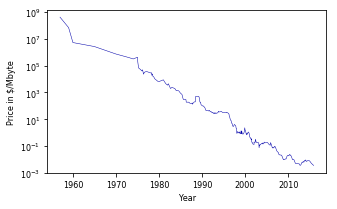

In [4]:
ram_prices = pd.read_csv('data/ram_price.csv')

plt.semilogy(ram_prices.date, ram_prices.price)
plt.xlabel("Year")
plt.ylabel("Price in $/Mbyte");

R2 score for Decision Tree Regressor:-50.768251705745726
R2 score for Linear Regressor:0.544625797018931
R2 score for Random Forrest Regressor:-30.27308712078529
R2 score for Lasso Regressor:0.07410323468475022
R2 score for Ridge Regressor:0.5439297728777106
R2 score for Gaussion Process Regressor:-3.785977922874581


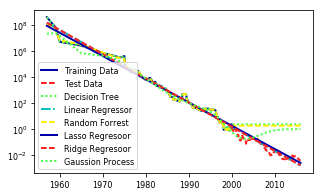

In [5]:
# Use historical data to forecast prices after the year 2000
data_train = ram_prices[ram_prices.date < 2000]
data_test = ram_prices[ram_prices.date >= 2000]

# predict prices based on date:
X_train = data_train.date[:, np.newaxis]
# we use a log-transform to get a simpler relationship of data to target
y_train = np.log(data_train.price)

tree = DecisionTreeRegressor().fit(X_train, y_train)
linear_reg = LinearRegression().fit(X_train, y_train)
forrest = RandomForestRegressor().fit(X_train, y_train)
lasso = Lasso().fit(X_train, y_train)
ridge = Ridge().fit(X_train, y_train)

kernel = GPy.kern.RBF(input_dim=1,variance=5,lengthscale=5)
gp = GPy.models.GPRegression(X_train, y_train[:, np.newaxis], kernel)

# predict on all data
X_all = ram_prices.date[:, np.newaxis]

pred_tree = tree.predict(X_all)
pred_lr = linear_reg.predict(X_all)
pred_forrest = forrest.predict(X_all)
pred_lasso = lasso.predict(X_all)
pred_ridge = ridge.predict(X_all)
pred_gp = gp.predict(X_all)[0]

# undo log-transform
price_tree = np.exp(pred_tree)
price_lr = np.exp(pred_lr)
price_forrest = np.exp(pred_forrest)
price_lasso = np.exp(pred_lasso)
price_ridge = np.exp(pred_ridge)
price_gp = np.exp(pred_gp)

plt.rcParams['lines.linewidth'] = 2
plt.semilogy(data_train.date, data_train.price, label="Training Data")
plt.semilogy(data_test.date, data_test.price, label="Test Data")
plt.semilogy(ram_prices.date, price_tree, label="Decision Tree")
plt.semilogy(ram_prices.date, price_lr, label="Linear Regressor")
plt.semilogy(ram_prices.date, price_forrest, label="Random Forrest")
plt.semilogy(ram_prices.date, price_lasso, label="Lasso Regresoor")
plt.semilogy(ram_prices.date, price_ridge, label="Ridge Regresoor")
plt.semilogy(ram_prices.date, price_gp, label="Gaussion Process")
plt.legend();

print('R2 score for Decision Tree Regressor:{}'
      .format(r2_score(data_test.price, np.exp(tree.predict(data_test.date[:, np.newaxis])))))

print('R2 score for Linear Regressor:{}'
      .format(r2_score(data_test.price, np.exp(linear_reg.predict(data_test.date[:, np.newaxis])))))

print('R2 score for Random Forrest Regressor:{}'
      .format(r2_score(data_test.price, np.exp(forrest.predict(data_test.date[:, np.newaxis])))))

print('R2 score for Lasso Regressor:{}'
      .format(r2_score(data_test.price, np.exp(lasso.predict(data_test.date[:, np.newaxis])))))

print('R2 score for Ridge Regressor:{}'
      .format(r2_score(data_test.price, np.exp(ridge.predict(data_test.date[:, np.newaxis])))))

print('R2 score for Gaussion Process Regressor:{}'
      .format(r2_score(data_test.price, np.exp(gp.predict(data_test.date[:, np.newaxis])[0]))))

### Performanc Analysis
- Decision tree and random forest perform terrible because they are not suitable for time series data. When they encounter features on unseen range, for example later than 2000, they simply return the mean value of the nearest class. And this is the reason why they gives a horizontal line after 2000.
- Gaussion process regerssor is also not quite good at time series data. Because it is sure about the range where training points have already apeared. When it comes to the ranges where no prevoius data point has occured, it tends to deviate from underling distribution.
- Linear regressor, as well as its varient, i.e. lasso and ridge, perform quite well. But it is based on the assumption that the underlying distribution is linear like.
- Linear regressor performs best according to R2 score. It reaches 0.545.

(1945, 2030)

(1945, 2030)

(1945, 2030)

(1945, 2030)

(1945, 2030)

(1945, 2030)

(1945, 2030)

(1945, 2030)

(1945, 2030)

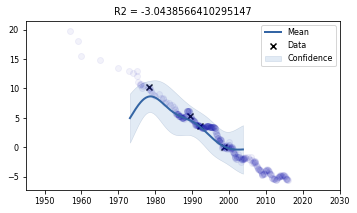

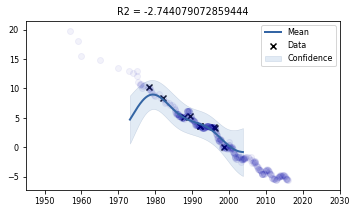

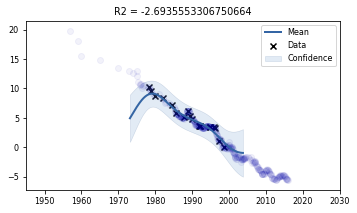

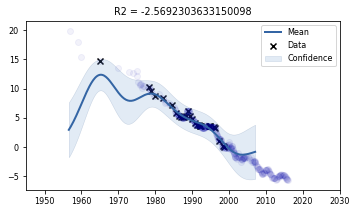

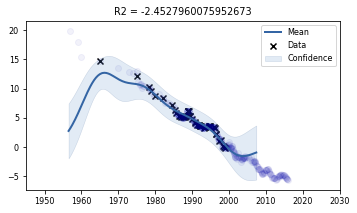

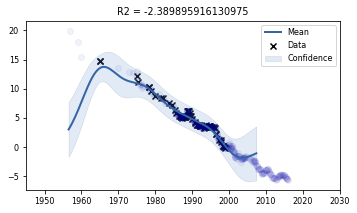

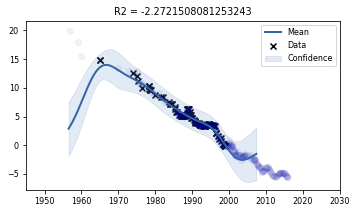

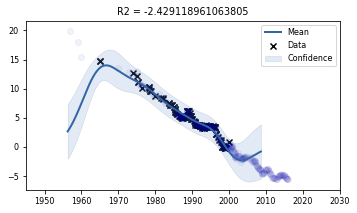

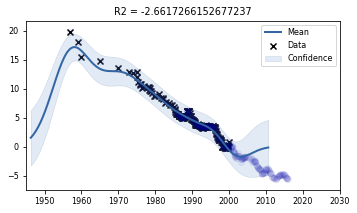

In [6]:
data_train = ram_prices[ram_prices.date < 2000]
data_test = ram_prices[ram_prices.date >= 2000]

X_train = data_train.date[:, np.newaxis]
y_train = np.log(data_train.price)[:, np.newaxis]
X_test = data_test.date[:, np.newaxis]
y_test = np.log(data_test.price)[:, np.newaxis]
X = ram_prices.date[:, np.newaxis]
y = np.log(ram_prices.price)[:, np.newaxis]

index = numpy.random.randint(1,len(X_train),len(X_train))

kernel = GPy.kern.RBF(input_dim=1,variance=5,lengthscale=5)

m1 = GPy.models.GPRegression(X[index[1:5]], y[index[1:5]], kernel)
m2 = GPy.models.GPRegression(X[index[1:10]], y[index[1:10]], kernel)
m3 = GPy.models.GPRegression(X[index[1:20]], y[index[1:20]], kernel)
m4 = GPy.models.GPRegression(X[index[1:30]], y[index[1:30]], kernel)
m5 = GPy.models.GPRegression(X[index[1:50]], y[index[1:50]], kernel)
m6 = GPy.models.GPRegression(X[index[1:70]], y[index[1:70]], kernel)
m7 = GPy.models.GPRegression(X[index[1:110]], y[index[1:110]], kernel)
m8 = GPy.models.GPRegression(X[index[1:150]], y[index[1:150]], kernel)
m9 = GPy.models.GPRegression(X_train, y_train, kernel)

m = [m1,m2,m3,m4,m5,m6,m7,m8,m9]
for i in m:
    fig = i.plot()
    fig.set_xlim(left=1945,right=2030)
    fig.scatter(X,y,alpha=0.05)
    fig.set_title('R2 = {}'.format(r2_score(y_test, i.predict(X_test)[0])))

### Compare these results with those achieved with other algorithms and explain.
- After comparing these results, I found out that the more data used for training, the narrower confidence interval is, which means it has more certainty with the result. But it only applies to the feature range that has already appeared. Intuitively, the price will keep going down. But the gaussion process regressor shows a rebound and a upgoing slope after the last data point.
- When compared with linear regressor, gaussion process regressor seems not suitable for this problem, which is time series. It is not able to predict future trend since 'year' will be landed into a new range where no previous data points has occured. Gaussion process regressor is not really sure about the area where no training data has occured and tends to yeild incorrect results in new range.

## A mini-data mining challenge (2 points (+1))

The goal here is to use everything you have learned to build the best model for a given classification task. The task is hosted on OpenML, so you will receive the train-test splits, and your model will be evaluated on the server. The goal is to reasonably select algorithms and hyperparameter settings to obtain the best model. You can also do model selection and parameter optimization as you have done before. Skeleton code is provided in the OpenML tutorial.

- All details can be found online:
    - The OpenML Task ID is 145677: https://www.openml.org/t/145677
    - The dataset description can be found here: https://www.openml.org/d/4134
- A leaderboard is kept of the best models: https://www.openml.org/t/145677#!people
    - You are able to see the solutions of others (by clicking in the timeline or run list), but resubmission of the exact same solution does not register on the leaderboard.
    - You can share one account (one API key) per team. In case you use two, we take the one that performs best.
- You can document the different experiments that you ran in this notebook. For each experiment, provide a description of how you chose the algorithms and parameters that you submitted. Try to reason about which experiments to try, don't just do an immense random search.
- Points are rewarded as follows:
    - 1 point for the breadth of experiments you ran (algorithms, hyperparameter settings)
    - 1 point for reasoning/insight and interpretation of the results
    - 1 (bonus) point for every team who has uploaded the best solution thus far **on AUC** (who reaches the top of the leaderboard at any moment during the assignment)
        - Note: On the leaderboard page, the 'frontier' line is drawn, and your top ranking is also shown in the table.
        
Note: Report AUC scores in your report as well. In case of issues with OpenML we will use the experiments and scores mentioned your report.

### Solution

This is a binary classification problem with huge feature amount (1777 numeric features). There are 3751 observations, which is big but still acceptable. The data set has already been preprocessed. There is no missing value and all features range from 0 to 1. 

When selecting models, I mainly consider whether the model can easily handel high dimentian and medium large data set, how long does it take to train, does it need parameter tuning.

Based on these criterions, I disgarded nearest neighbors model because it can hardly handle large data set. I did not apply decision tree because it overfits easily and is exceled by random forest and gradient boosting usually. I did not use gradient boost, either, because it takes too long to train. I prefer logistc regression and SVMs because they do well with high dimentianal data, and random forest because it does not need much tuning and is usually powerful.

First I would love to try random forest. Because doing experiments is really time consuming, I make full use of the results that others have already done and uploaded onto the leader board.

![NB](./All_runs.png)
![NB](./All_parameters.png)
![NB](./All_parameters2.png)

As is shown in the first image, the best performance was given by random forrest classifier, which approximates 100%. And we can see in the second picture that, the most important parameter that can boost the performance is 'warm_start'. If we set this parameter to true, the classifier will reuse the solution of the previous call to fit and add more estimators to the ensemble, otherwise, just fit a whole new forest. With this parameter true, people tried max_feature from 0.1% to 256(approximately 13%), n_estimators from 64 to 9192. Though fewer features and more estimators seems yield better performance, they do not really have big gap among each other.

If we ignore 'warm_start', the best is still from random forest, which reaches 88.7%. The best hyperparameter is that 'max_feature' = 10% and 'n_estimators' = 1024 or 2048.

Best AUC is 0.8294511559992362, obtained with
	penalty = l2
	C = 0.01


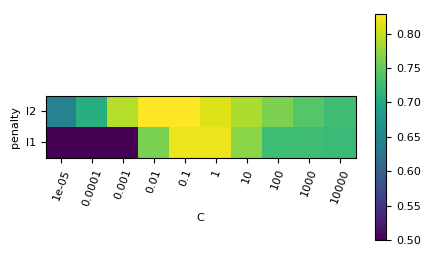

In [8]:
task = tasks.get_task(145677)
X, y = task.get_X_and_y()

DEBUG = False

if DEBUG:
    print('*** DEBUG RUN ***')

pg_lr={
    'penalty': ['l1'],
    'C': [10**x for x in range(-1,1,1)]
} if DEBUG else {
    'penalty': ['l1','l2'],
    'C': [10**x for x in range(-5,5,1)]
}

gs = GridSearchCV(LogisticRegression(), param_grid=pg_lr, cv=5,
                      n_jobs=-1, scoring='roc_auc');
gs.fit(X, y);

print('Best AUC is {}, obtained with\n\tpenalty = {}'
      '\n\tC = {}'.format(
          
    gs.best_score_, gs.best_params_['penalty'],
    gs.best_params_['C']
));

scores = np.array(gs.cv_results_['mean_test_score']).reshape(
    len(pg_lr['C']),
    len(pg_lr['penalty'])
).T;

img = mglearn.tools.heatmap(
    scores, cmap='viridis', fmt='',
    ylabel='penalty', yticklabels=pg_lr['penalty'],
    xlabel='C', xticklabels=pg_lr['C'],
);

plt.colorbar(img);
plt.setp(img.get_axes().xaxis.get_majorticklabels(),
         rotation=70);
plt.show();

In [6]:
DEBUG = False

task = tasks.get_task(145677)
X, y = task.get_X_and_y()

if DEBUG:
    print('*** DEBUG RUN ***')

pg_svc={
    'C': [10**x for x in range(-1, 1, 1)],
    'gamma': [10**x for x in range(-1, 1, 1)],
} if DEBUG else {
    'C': [10**x for x in range(-5,5,1)],
    'gamma': [10**x for x in range(-5,5,1)],
}

gs_svc = GridSearchCV(SVC(), param_grid=pg_svc, cv=5,
                      n_jobs=-1, scoring='roc_auc');
gs_svc.fit(X, y);

print('Best AUC is {}, obtained with\n\tC = {}'
      '\n\tgamma = {}'.format(
          
    gs_svc.best_score_, gs_svc.best_params_['C'],
    gs_svc.best_params_['gamma']
));

Best AUC is 0.8528528112114501, obtained with
	C = 10
	gamma = 0.01


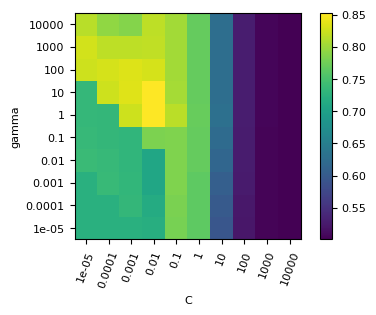

In [7]:
scores = np.array(gs_svc.cv_results_['mean_test_score']).reshape(
    len(pg_svc['gamma']),
    len(pg_svc['C'])
);

img = mglearn.tools.heatmap(
    scores, cmap='viridis', fmt='',
    ylabel='gamma', yticklabels=pg_svc['gamma'],
    xlabel='C', xticklabels=pg_svc['C'],
);

plt.colorbar(img);
plt.setp(img.get_axes().xaxis.get_majorticklabels(),
         rotation=70);
plt.show();

Best AUC is 0.832012280745508, obtained with
	penalty = l2
	C = 0.03


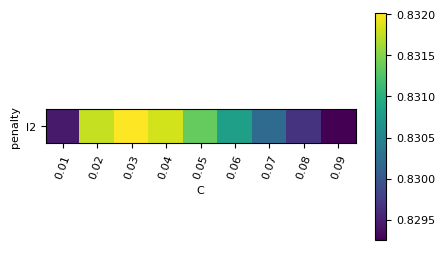

In [9]:
task = tasks.get_task(145677)
X, y = task.get_X_and_y()

DEBUG = False

if DEBUG:
    print('*** DEBUG RUN ***')

pg_lr={
    'penalty': ['l1'],
    'C': [x/100 for x in range(1,10,1)]
} if DEBUG else {
    'penalty': ['l2'],
    'C': [x/100 for x in range(1,10,1)]
}

gs = GridSearchCV(LogisticRegression(), param_grid=pg_lr, cv=5,
                      n_jobs=-1, scoring='roc_auc');
gs.fit(X, y);

print('Best AUC is {}, obtained with\n\tpenalty = {}'
      '\n\tC = {}'.format(
          
    gs.best_score_, gs.best_params_['penalty'],
    gs.best_params_['C']
));

scores = np.array(gs.cv_results_['mean_test_score']).reshape(
    len(pg_lr['C']),
    len(pg_lr['penalty'])
).T;

img = mglearn.tools.heatmap(
    scores, cmap='viridis', fmt='',
    ylabel='penalty', yticklabels=pg_lr['penalty'],
    xlabel='C', xticklabels=pg_lr['C'],
);

plt.colorbar(img);
plt.setp(img.get_axes().xaxis.get_majorticklabels(),
         rotation=70);
plt.show();

### Conclusion
- After careful tuning, SVC reaches 85%, and logistic regressor reaches 83%.
- Though SVC and logistic regressor are supposed to be more suitable for this problem, but they are outperformed, badly, by random forest classifier. 
- We reached the top once with the name 'Hongliang Qiu'